# Installing Dependencies

In [30]:
pip_list = !pip list
packages = ["chardet", "dabl", "imblearn", "keras-tuner", "mysql-connector-python", "numpy", "pandas", "sklearn", "statsmodels", "tensorflow", "xgboost"]
for package in packages:
    if not pip_list.grep(package):
        !pip3 install {package}

print("Package installations completed.")

Package installations completed.


# Importing Modules

In [31]:
import calendar
import datetime
import os
import shutil
import warnings
from pickle import dump

import chardet
import matplotlib.pyplot as plt
import mysql.connector
import numpy as np
import pandas as pd
import requests
import scipy.stats as stat
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
from dabl import SimpleClassifier, SimpleRegressor, clean, plot
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from IPython.display import display
from keras_tuner.tuners import BayesianOptimization, Hyperband, RandomSearch
from mysql.connector import errorcode
from sklearn import set_config
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.feature_selection import (SelectPercentile, VarianceThreshold,
                                       chi2, f_classif)
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, StratifiedKFold,
                                     train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (MinMaxScaler, OneHotEncoder, OrdinalEncoder,
                                   StandardScaler)
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib
from xgboost import XGBClassifier, XGBRegressor

%matplotlib inline
time_stamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
set_config(display="diagram", print_changed_only=False)
pd.set_option("display.float_format", lambda f: "%.2f" % f)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
plt.rc("axes", labelsize=12)
plt.rc("axes", titlesize=12)
plt.rc("font", size=10)
plt.rcParams["figure.figsize"] = [18, 7]
plt.style.use("dark_background")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings("ignore")

print(device_lib.list_local_devices())
print(tf.config.list_physical_devices("GPU"))
print(tf.test.gpu_device_name())
print(os.system("cat /proc/cpuinfo | grep 'model name'"))
print(os.system("cat /proc/meminfo | grep 'MemTotal'"))
print(os.system("nvidia-smi"))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1846382134326207958
]
[]

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
0
MemTotal:       32880876 kB
0
32512


sh: 1: nvidia-smi: not found


# Reading Data

In [32]:
url = "https://raw.githubusercontent.com/lyoh001/AzureML/main/data.csv"
df = pd.read_csv(url, delimiter=",", encoding=chardet.detect(requests.get(url).content)["encoding"], thousands=",")
display(df)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.00,98.00,86,high risk
1,35,140,90,13.00,98.00,70,high risk
2,29,90,70,8.00,100.00,80,high risk
3,30,140,85,7.00,98.00,70,high risk
4,35,120,60,6.10,98.00,76,low risk
...,...,...,...,...,...,...,...
1007,22,120,60,15.00,98.00,80,high risk
1008,55,120,90,18.00,98.00,60,high risk
1009,35,85,60,19.00,98.00,86,high risk
1010,43,120,90,18.00,98.00,70,high risk


# Defining params

In [33]:
RANDOM_STATE = 11
SEARCH = ["hyperband", "random", "bayesian"][0]
EPOCHS = 500
MAX_TRIALS = 20
DUPLICATES = 1
SCALER = 1
CLASSIFICATION = 2

print("-------------------------------------------------------")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Duplicates Percentage: {df.duplicated().sum() / df.shape[0] * 100:.2f}%")
if DUPLICATES:
    print(f"Duplicates have been kept {df.shape}.")
else:
    df.drop_duplicates(inplace=True)
    print(f"Duplicates have been removed {df.shape}.")
display(df.sample(3))
y_label = "RiskLevel"

-------------------------------------------------------
Current Shape: (1012, 7).
-------------------------------------------------------
Duplicates Percentage: 55.43%
Duplicates have been kept (1012, 7).


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
435,65,130,80,15.00,98.00,86,high risk
970,50,120,80,15.00,98.00,70,high risk
285,13,90,65,9.00,101.00,80,high risk


# Mapping target values (Low Risk -> 0, Mid Risk -> 1, High Risk -> 2)

In [34]:
df.dropna(subset=[y_label], inplace=True)
print("-------------------------------------------------------")
print(f"Dropping null target values.")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
df[y_label] = df[y_label].map({"low risk": 0 , "mid risk": 1, "high risk": 2})
print(f"y Value Counts:\n{df[y_label].value_counts()}")

-------------------------------------------------------
Dropping null target values.
Current Shape: (1012, 7).
-------------------------------------------------------
y Value Counts:
0    404
1    336
2    272
Name: RiskLevel, dtype: int64


# Correlation Matrix

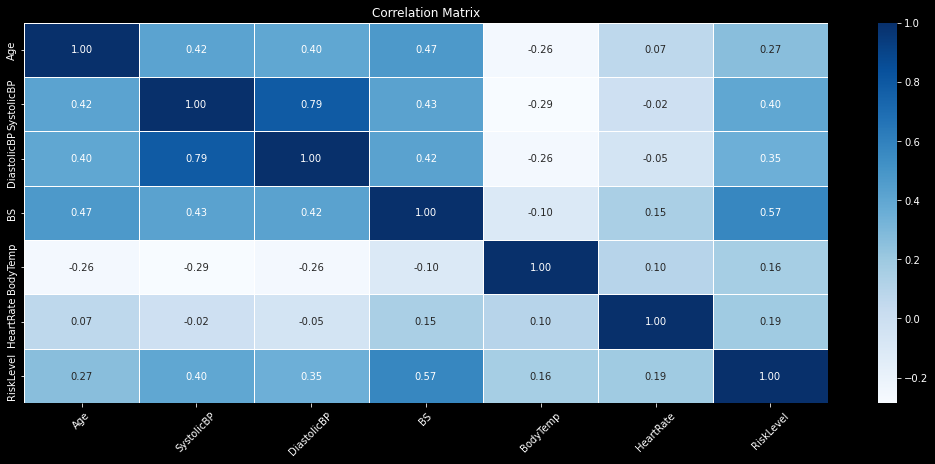

In [35]:
sns.heatmap(df.corr(), cmap="Blues", fmt=".2f", annot=True, linewidths=1)
plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.show()

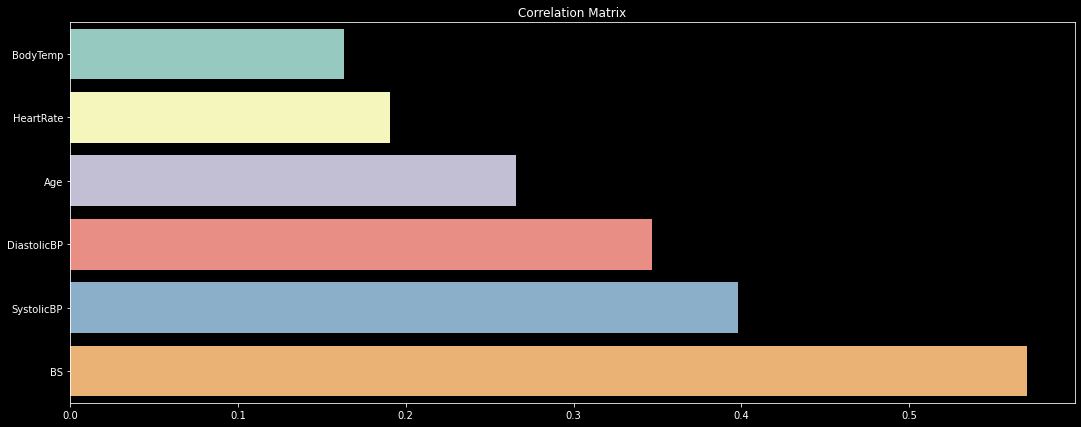

In [36]:
corr_matrix = df.corr()[y_label].sort_values().drop(y_label)
sns.barplot(x=corr_matrix.values, y=corr_matrix.index).set_title("Correlation Matrix")
plt.show()

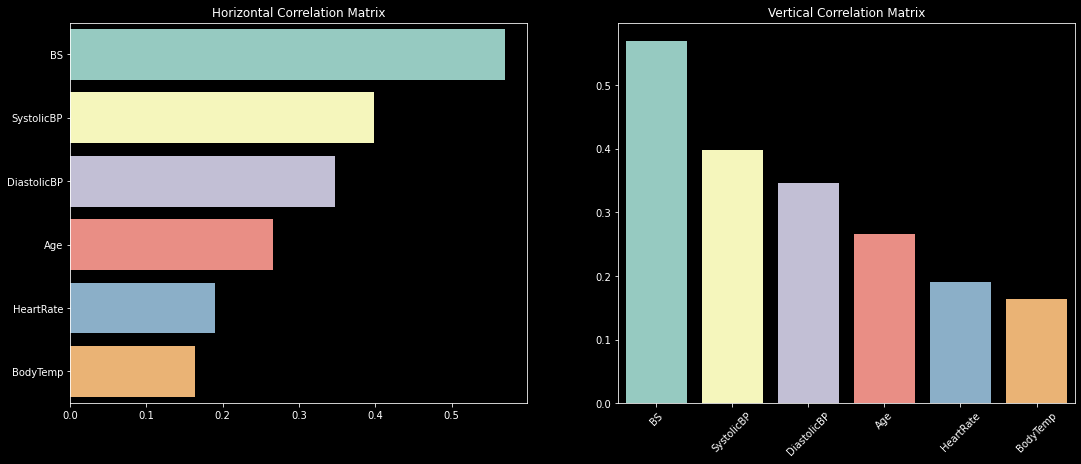

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2)
corr_matrix = df.corr()[y_label].abs().sort_values(ascending=False).drop(y_label)
sns.barplot(x=corr_matrix.values, y=corr_matrix.index, ax=ax[0]).set_title("Horizontal Correlation Matrix")
sns.barplot(x=corr_matrix.index, y=corr_matrix.values, ax=ax[1]).set_title("Vertical Correlation Matrix")
plt.xticks(rotation=45)
plt.show()

In [38]:
def correlation(X, threshold):
    col_corr = set()
    df_corr = X.corr().abs()
    for i, _ in enumerate(df_corr.columns):
        for j in range(i):
            if (df_corr.iloc[i, j] >= threshold) and (
                df_corr.columns[j] not in col_corr
            ):
                col_corr.add(df_corr.columns[i])
    return col_corr

col_drop = correlation(df.drop(y_label, axis=1), 0.85)
df.drop(col_drop, inplace=True, axis=1)
print("-------------------------------------------------------")
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"Highly correlated cols have been removed: {len(col_drop)}.")
print(f"Highly correlated cols: {col_drop}.")

-------------------------------------------------------
Current Shape: (1012, 7).
-------------------------------------------------------
Highly correlated cols have been removed: 0.
Highly correlated cols: set().


# Checking NULL values

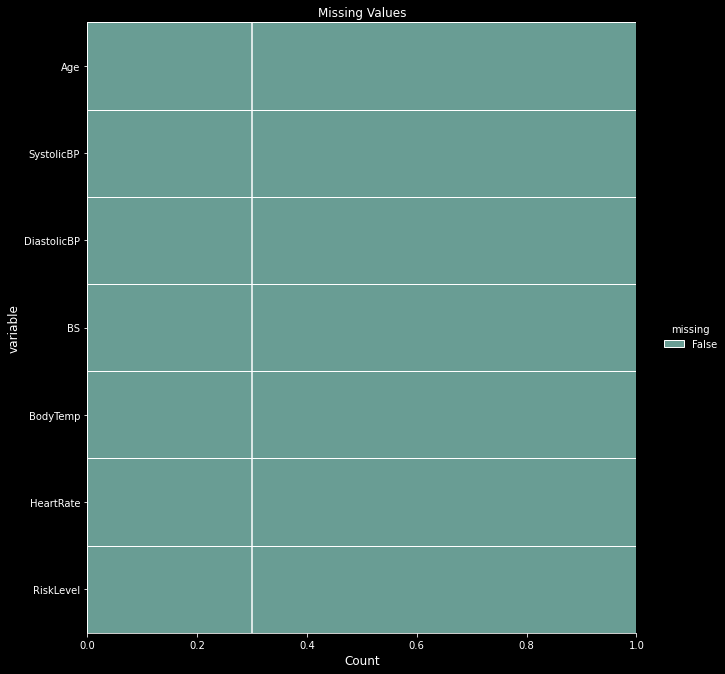

In [39]:
sns.displot(
    data=df.isnull().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    height=9.25,
)
plt.axvline(0.3, color="white")
plt.title("Missing Values")
plt.show()

# Dropping 2 rows as "Heart Rate" cannot be equal to 7

In [40]:
display(df[df["HeartRate"] < 50])
df.drop(df[df["HeartRate"] < 50].index, inplace=True)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel


# Feature Description

In [41]:
col_cat_oe = []
preprocessor_cat_oe = make_pipeline(
    (SimpleImputer(strategy="most_frequent")),
    (OrdinalEncoder(categories=[["", ""]])),
)
col_cat = [col for col in df.columns if np.issubsctype(df[col].dtype, np.object0) and col != y_label]
col_num = [col for col in df.columns if np.issubsctype(df[col].dtype, np.number) and col != y_label]
col_cat_ohe = [col for col in col_cat if col not in col_cat_oe]
col_num_disc = [col for col in col_num if df[col].nunique() < 5]
col_num_cont = [col for col in col_num if col not in col_num_disc]

df_info = pd.DataFrame(
    {
        "column": [col for col in df.columns],
        "dtype": [f"{df[col].dtype}" for col in df.columns],
        "na": [f"{df[col].isna().sum()}" for col in df.columns],
        "na %": [f"{round(df[col].isna().sum() / df[col].shape[0] * 100)}%" for col in df.columns],
        "outliers": [f"{((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()}" if col in col_num else "n/a" for col in df.columns],
        "outliers %": [f"{round((((df[col] < (df[col].quantile(0.25) - 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25)))) | (df[col] > (df[col].quantile(0.75) + 1.5 * (df[col].quantile(0.75) - df[col].quantile(0.25))))).sum()) / df[col].shape[0] * 100)}%" if col in col_num else "n/a" for col in df.columns],
        "kurtosis": [f"{df[col].kurtosis(axis=0, skipna=True):.2f}" if col in col_num else "n/a" for col in df.columns],
        "skewness": [f"{df[col].skew(axis=0, skipna=True):.2f}" if col in col_num else "n/a" for col in df.columns],
        "corr": [f"{round(df[col].corr(other=df[y_label]) * 100)}%" if col in col_num else "n/a" for col in df.columns],
        "nunique": [f"{df[col].nunique()}" for col in df.columns],
        "unique": [sorted(df[col].unique()) if col in col_num else df[col].unique() for col in df.columns],
    }
).sort_values(by="dtype", ascending=False)
display(df_info)
print(f"Current Shape: {df.shape}.")
print("-------------------------------------------------------")
print(f"total na %: {df.isnull().sum().sum() / np.product(df.shape) * 100:.2f}%")
print("-------------------------------------------------------")
print(f"col_cat_oe ({len(col_cat_oe)}): {col_cat_oe}")
print(f"col_cat_ohe ({len(col_cat_ohe)}): {col_cat_ohe}")
print(f"col_num_disc ({len(col_num_disc)}): {col_num_disc}")
print(f"col_num_cont ({len(col_num_cont)}): {col_num_cont}")
print("-------------------------------------------------------")
print(f"total cols for preprocessor: {len(col_cat_oe) + len(col_cat_ohe) + len(col_num_disc) + len(col_num_cont)}")

,column,dtype,na,na %,outliers,outliers %,kurtosis,skewness,corr,nunique,unique
0,Age,int64,0,0%,1,0%,-0.39,0.78,27%,50,"[10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2..."
1,SystolicBP,int64,0,0%,10,1%,-0.62,-0.25,40%,19,"[70, 75, 76, 78, 80, 83, 85, 90, 95, 99, 100, ..."
2,DiastolicBP,int64,0,0%,0,0%,-0.95,-0.05,35%,16,"[49, 50, 60, 63, 65, 68, 69, 70, 75, 76, 80, 8..."
5,HeartRate,int64,0,0%,0,0%,-0.48,0.07,19%,15,"[60, 65, 66, 67, 68, 70, 75, 76, 77, 78, 80, 8..."
6,RiskLevel,int64,0,0%,n/a,n/a,n/a,n/a,n/a,3,"[2, 0, 1]"
3,BS,float64,0,0%,210,21%,2.29,1.87,57%,29,"[6.0, 6.1, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, ..."
4,BodyTemp,float64,0,0%,210,21%,1.44,1.75,16%,8,"[98.0, 98.4, 98.6, 99.0, 100.0, 101.0, 102.0, ..."


Current Shape: (1012, 7).
-------------------------------------------------------
total na %: 0.00%
-------------------------------------------------------
col_cat_oe (0): []
col_cat_ohe (0): []
col_num_disc (0): []
col_num_cont (6): ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
-------------------------------------------------------
total cols for preprocessor: 6


# Distplot of Risk Level

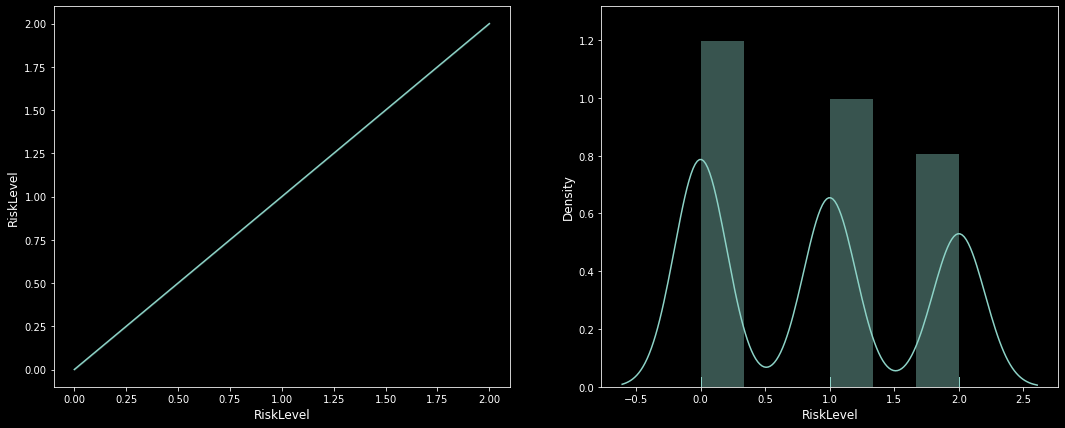

In [42]:
for col in col_num_disc + ([y_label] if CLASSIFICATION else []):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    sns.lineplot(x=df[col], y=df[y_label], ax=ax[0]).set_xlabel(f"{col}")
    sns.distplot(x=df[col], ax=ax[1], rug=True).set_xlabel(f"{col}")
plt.show()

# Distplot, Boxplot and QQplot for analysing statistical distribution of each feature

-------------------------------------------------------
Age
Skew: 0.78
Kurtosis: -0.39


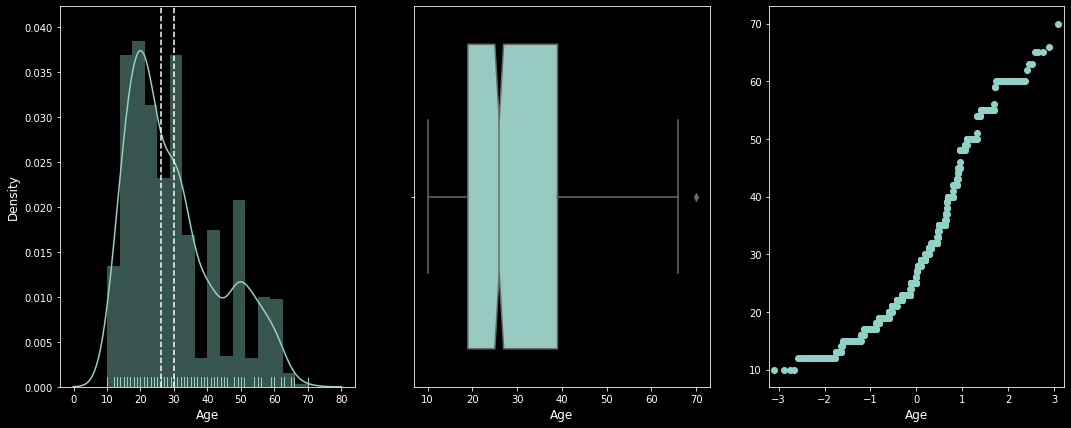

-------------------------------------------------------
SystolicBP
Skew: -0.25
Kurtosis: -0.62


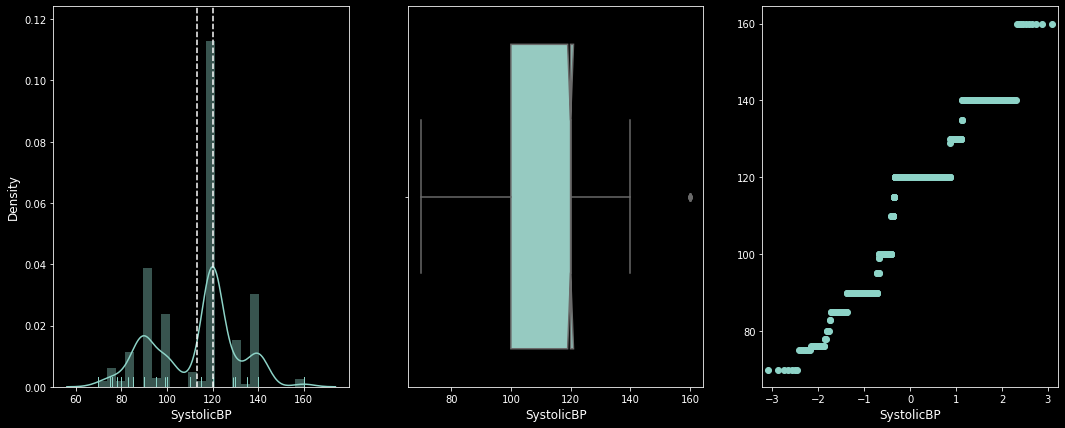

-------------------------------------------------------
DiastolicBP
Skew: -0.05
Kurtosis: -0.95


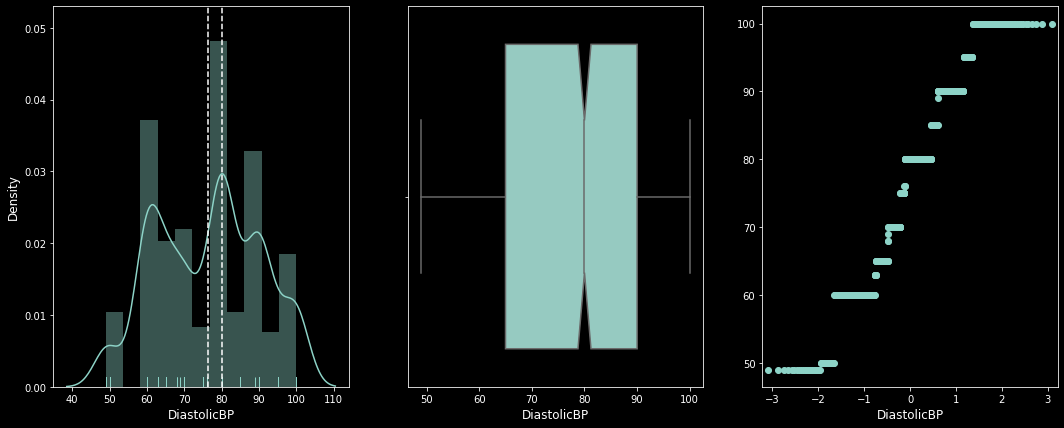

-------------------------------------------------------
BS
Skew: 1.87
Kurtosis: 2.29


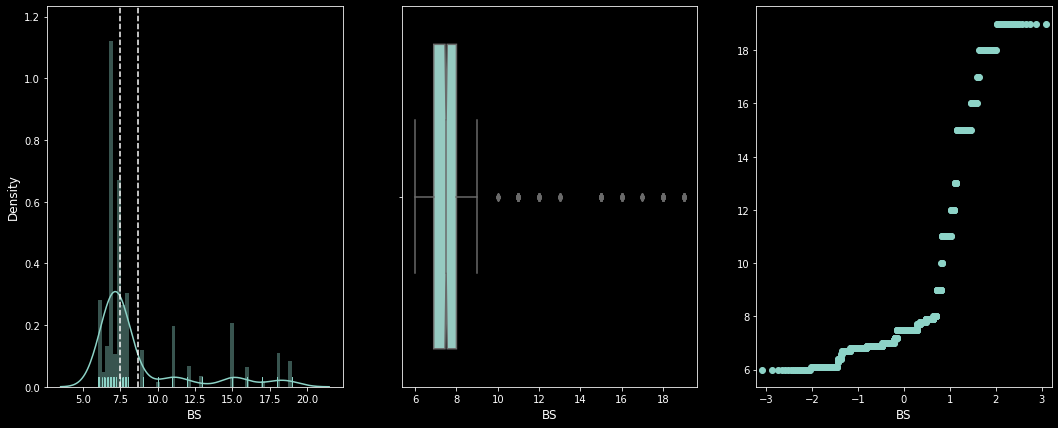

-------------------------------------------------------
BodyTemp
Skew: 1.75
Kurtosis: 1.44


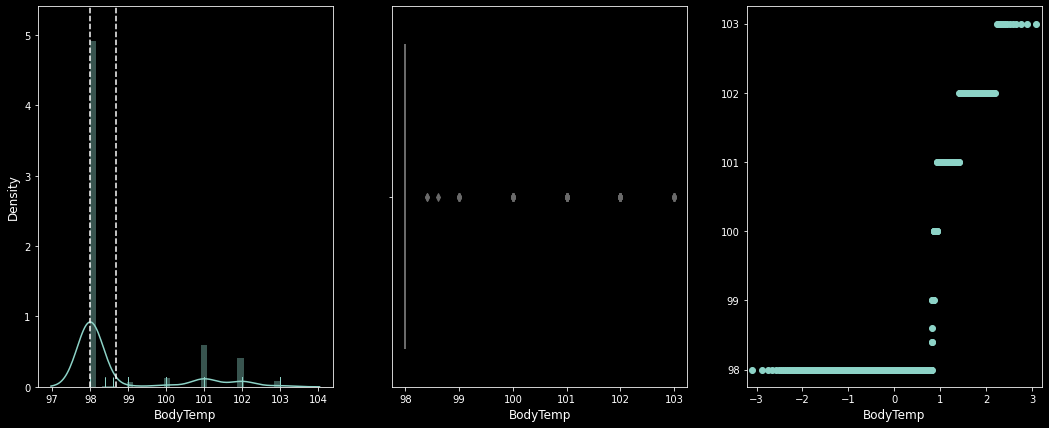

-------------------------------------------------------
HeartRate
Skew: 0.07
Kurtosis: -0.48


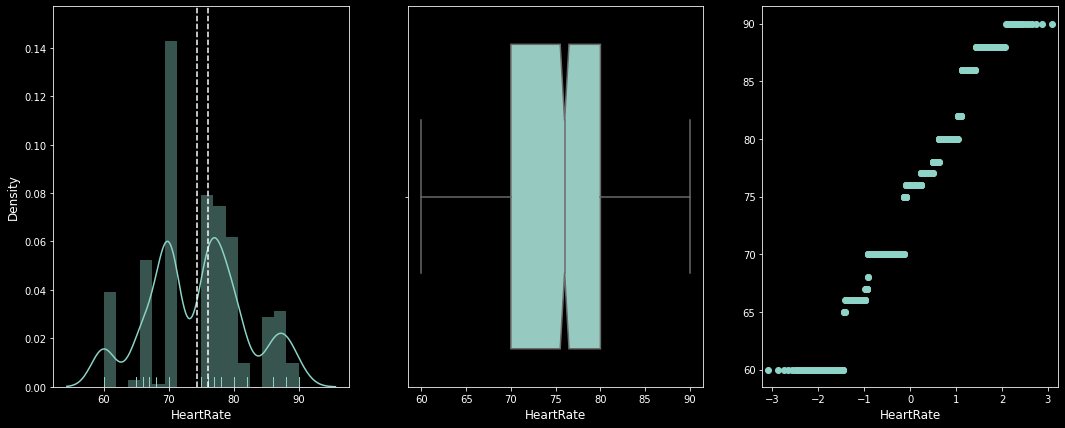

In [43]:
for col in col_num_cont + ([] if CLASSIFICATION else [y_label]):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    sns.distplot(x=df[col], ax=ax[0], rug=True).set_xlabel(f"{col}")
    sns.boxplot(x=df[col], ax=ax[1], notch=True).set_xlabel(f"{col}")
    sm.qqplot(data=df[col], ax=ax[2], xlabel=col, ylabel="")
    ax[0].axvline(x=df[col].mean(), linestyle="--")
    ax[0].axvline(x=df[col].median(), linestyle="--")
    print("-------------------------------------------------------")
    print(f"{col}\nSkew: {df[col].skew(axis=0, skipna=True):.2f}\nKurtosis: {df[col].kurtosis(axis=0, skipna=True):.2f}")
    plt.show()

# Examining BS for potential transformation to fit into Gaussian Distribution

-------------------------------------------------------
BS Keep Transformation
Skew: 1.87
Kurtosis: 2.29


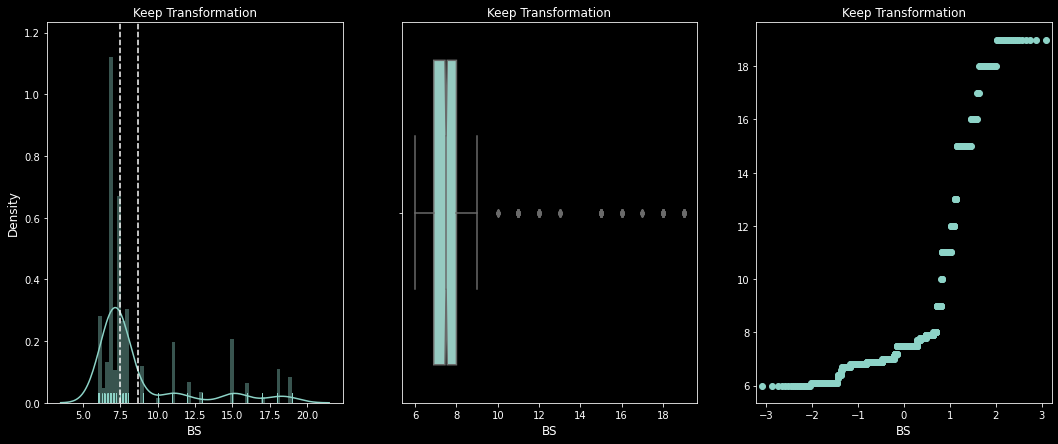

-------------------------------------------------------
BS Log Transformation
Skew: 1.52
Kurtosis: 1.08


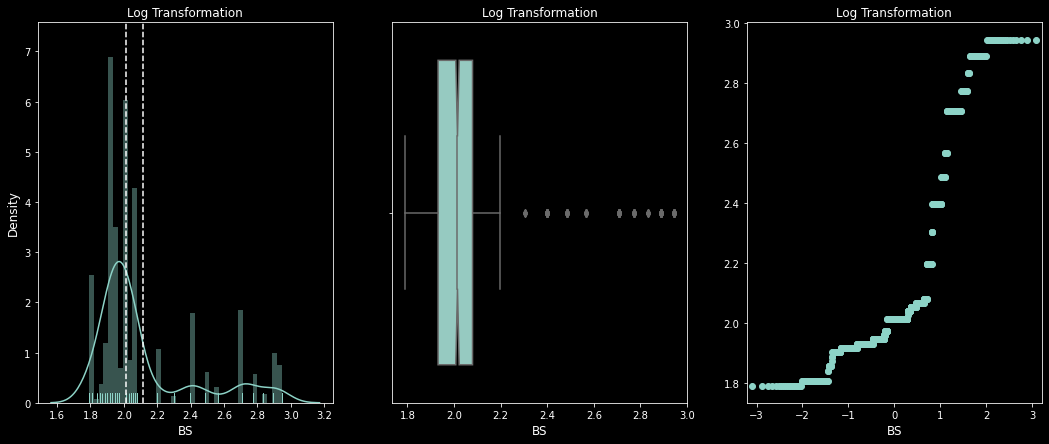

-------------------------------------------------------
BS Log1P Transformation
Skew: 1.55
Kurtosis: 1.17


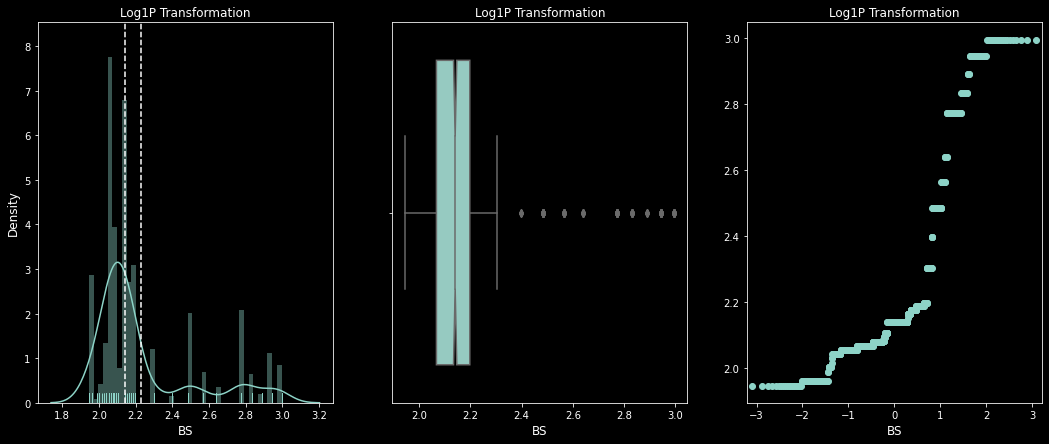

-------------------------------------------------------
BS Reciprocal Transformation
Skew: -1.15
Kurtosis: 0.22


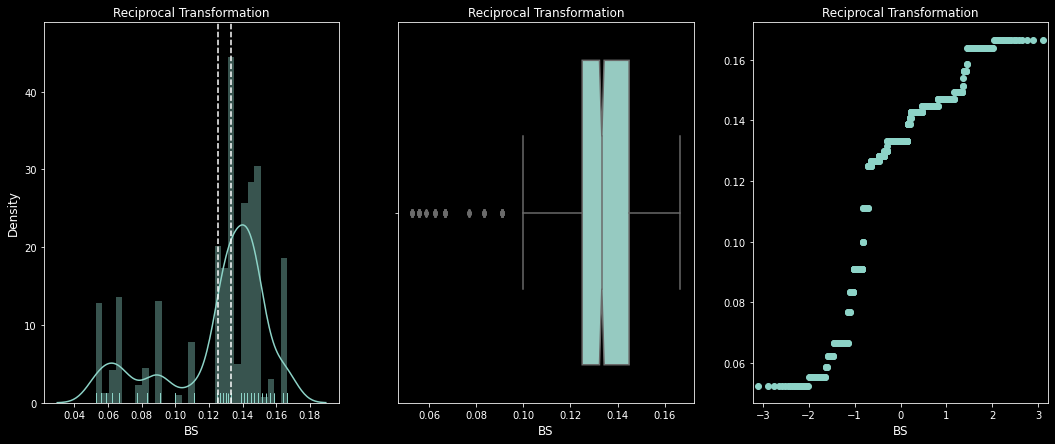

-------------------------------------------------------
BS Sqrt Transformation
Skew: 1.69
Kurtosis: 1.64


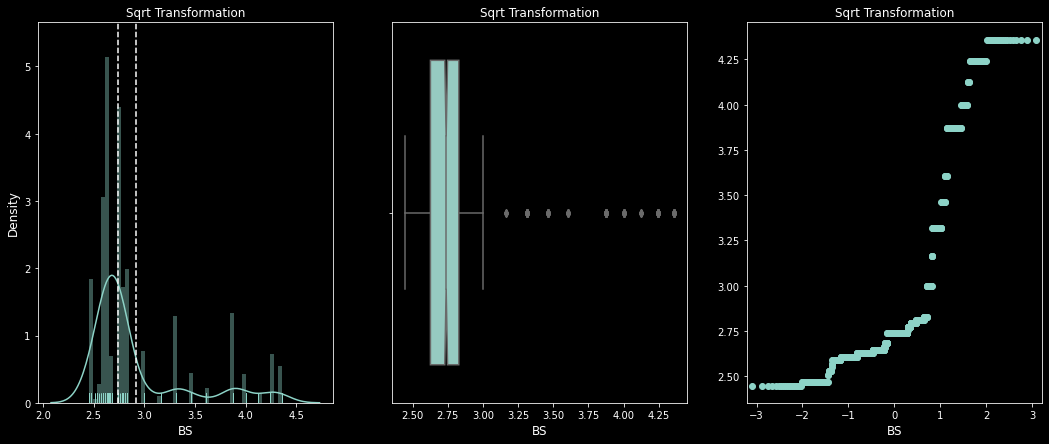

-------------------------------------------------------
BS Exp Transformation
Skew: 1.81
Kurtosis: 2.07


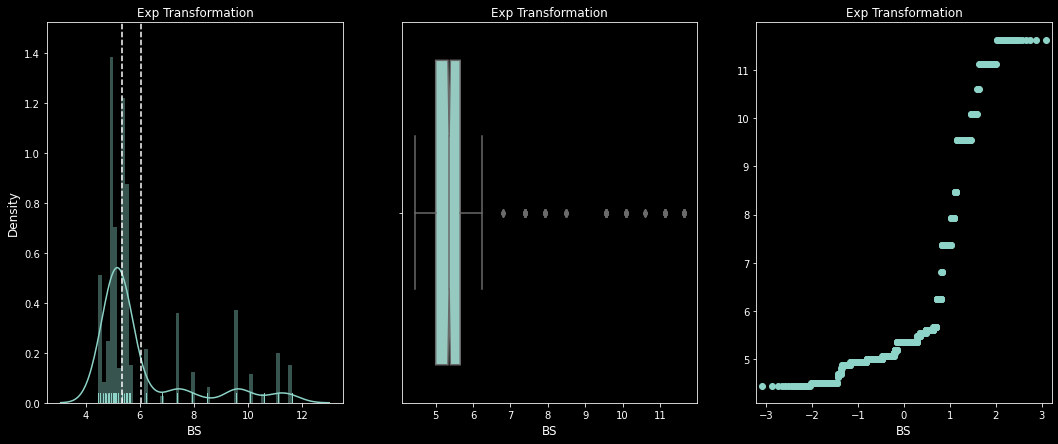

-------------------------------------------------------
BS Boxcox Transformation
Skew: 0.36
Kurtosis: -0.45


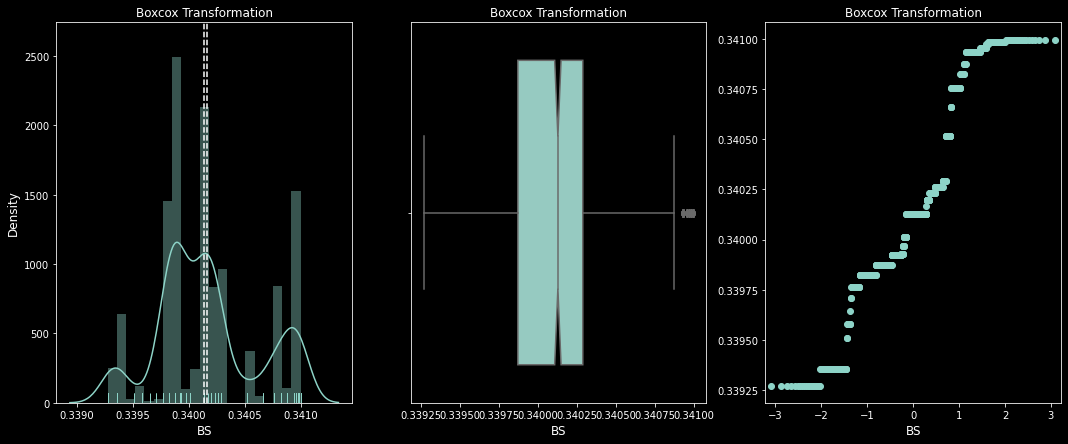

-------------------------------------------------------
BS Boxcox1 Transformation
Skew: 0.38
Kurtosis: -0.47


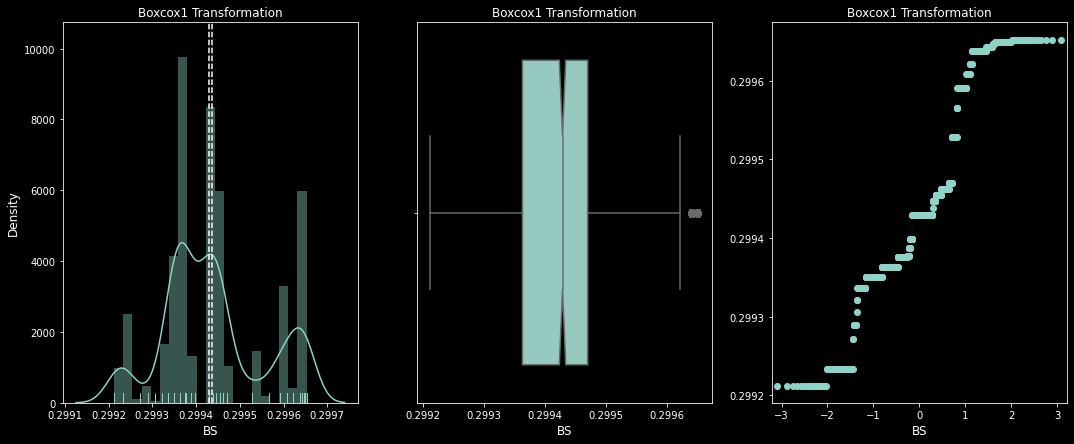

In [44]:
for col in ["BS"]:
    for trans in ["keep", "log", "log1p", "reciprocal", "sqrt", "exp", "boxcox", "boxcox1"]:
        try:
            fig, ax = plt.subplots(nrows=1, ncols=3)
            if trans == "keep":
                x = df[col]
            elif trans == "log":
                x = np.log(df[col])
            elif trans == "log1p":
                x = np.log1p(df[col])
            elif trans == "reciprocal":
                x=(1 / df[col])
            elif trans == "sqrt":
                x=(df[col] ** 0.5)
            elif trans == "exp":
                x=(df[col] ** (1/1.2))
            elif trans == "boxcox":
                x=pd.Series(stat.boxcox(df[col])[0], name=col)
            else:
                x=pd.Series(stat.boxcox(df[col] + 1)[0], name=col)
            sns.distplot(x=x, ax=ax[0], rug=True).set_xlabel(f"{col}")
            sns.boxplot(x=x, ax=ax[1], notch=True).set_xlabel(f"{col}")
            sm.qqplot(data=x, ax=ax[2], xlabel=col, ylabel="")
            ax[0].axvline(x=x.mean(), linestyle="--")
            ax[0].axvline(x=x.median(), linestyle="--")
        except Exception:
            pass
        finally:
            for i in range(3):
                ax[i].set_title(f"{trans.title()} Transformation")
            print("-------------------------------------------------------")
            print(f"{col} {trans.title()} Transformation\nSkew: {x.skew(axis=0, skipna=True):.2f}\nKurtosis: {x.kurtosis(axis=0, skipna=True):.2f}")
            plt.show()

# Boxplots for Numeric Columns

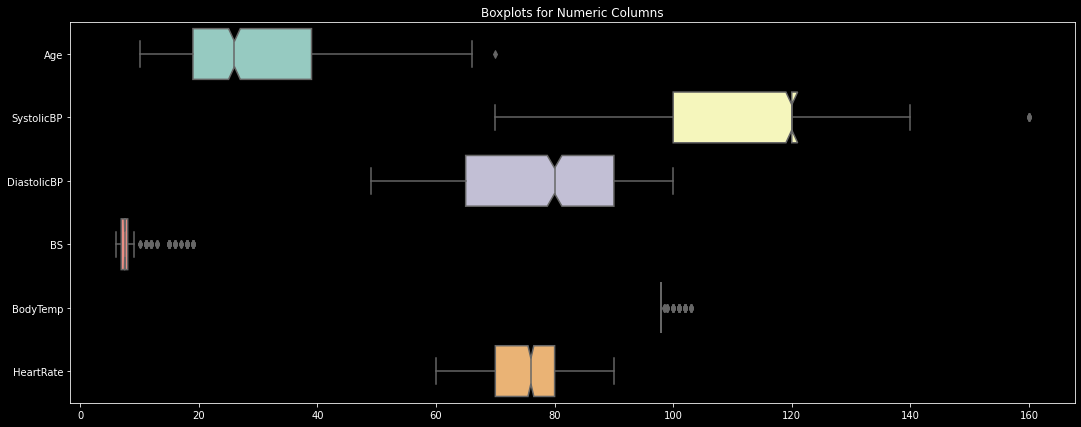

In [45]:
if col_num_cont:
    plt.title("Boxplots for Numeric Columns")
    sns.boxplot(data=df[[col for col in col_num_cont]], orient="h", notch=True)
    plt.show()

# Standard distribution and interquantile

In [46]:
display(df.describe().T.style.background_gradient(cmap="Blues").format("{:.2f}"))
display(df.quantile([0.01, 0.99]).T.style.background_gradient(cmap="Blues").format("{:.2f}"))

,count,mean,std,min,25%,50%,75%,max
Age,1012.00,29.90,13.47,10.00,19.00,26.00,39.00,70.00
SystolicBP,1012.00,113.18,18.42,70.00,100.00,120.00,120.00,160.00
DiastolicBP,1012.00,76.46,13.90,49.00,65.00,80.00,90.00,100.00
BS,1012.00,8.73,3.30,6.00,6.90,7.50,8.00,19.00
BodyTemp,1012.00,98.67,1.37,98.00,98.00,98.00,98.00,103.00
HeartRate,1012.00,74.43,7.52,60.00,70.00,76.00,80.00,90.00
RiskLevel,1012.00,0.87,0.81,0.00,0.00,1.00,2.00,2.00


,0.01,0.99
Age,12.00,60.00
SystolicBP,75.00,140.00
DiastolicBP,49.00,100.00
BS,6.00,19.00
BodyTemp,98.00,103.00
HeartRate,60.00,90.00
RiskLevel,0.00,2.00


# Plotting for visualization

Target looks like classification
Linear Discriminant Analysis training set score: 0.589


[[<Figure size 648x648 with 12 Axes>,
  <Figure size 1152x288 with 4 Axes>,
  <Figure size 288x288 with 1 Axes>],
 None]

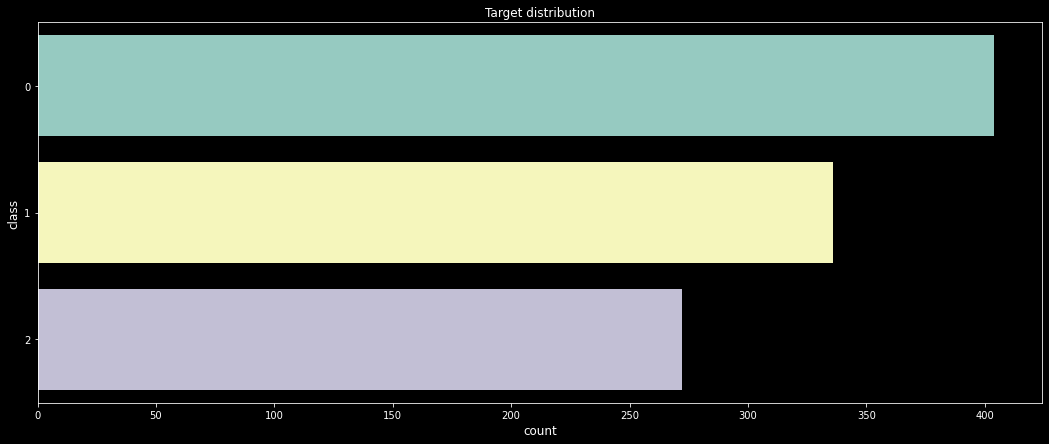

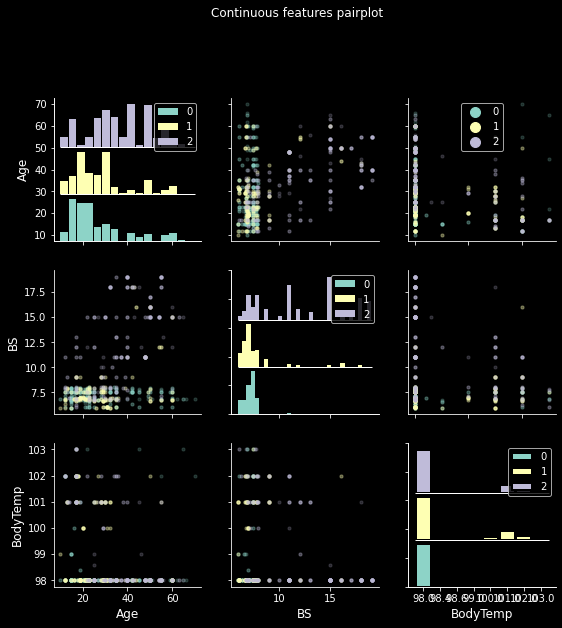

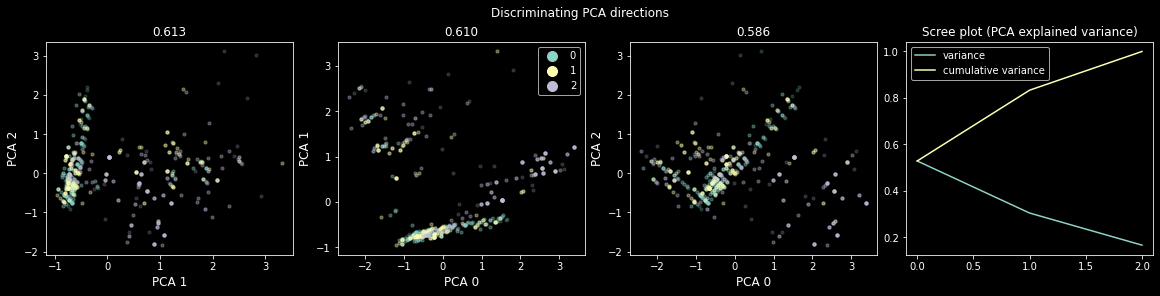

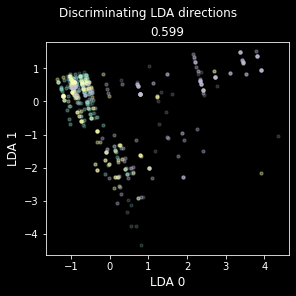

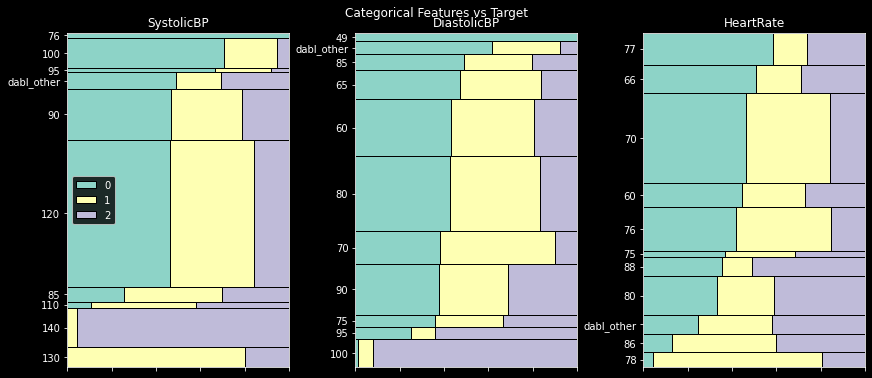

In [47]:
plot(df.drop(y_label, axis=1), df[y_label])

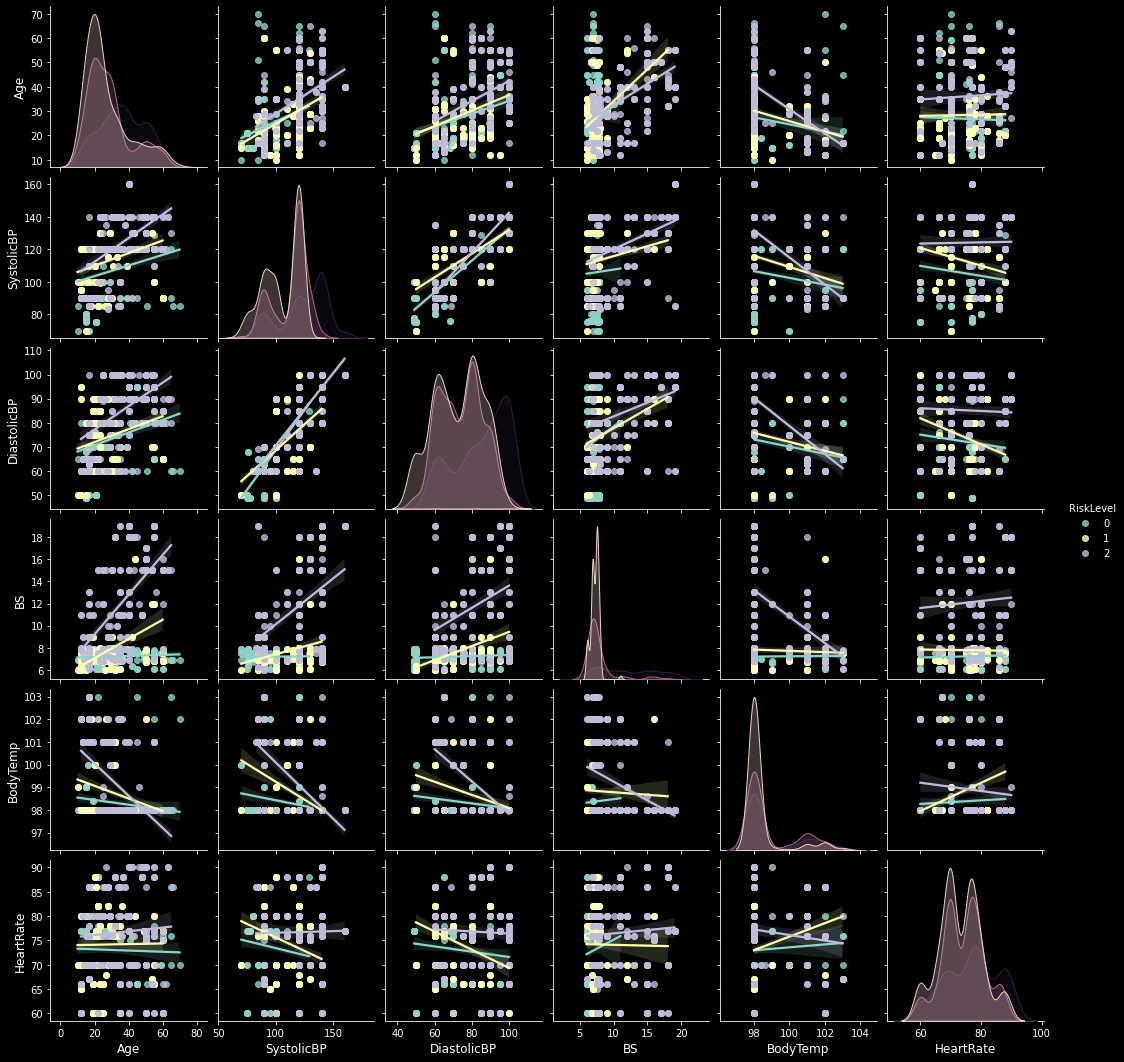

In [48]:
sns.pairplot(df, hue=y_label if CLASSIFICATION else None, kind="reg")

Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate',
       'RiskLevel'],
      dtype='object')


,RiskLevel,Age,Count
0,0,10,2
1,0,12,15
2,0,13,2
3,0,15,56
4,0,16,8
...,...,...,...
100,2,55,17
101,2,56,1
102,2,60,7
103,2,63,2


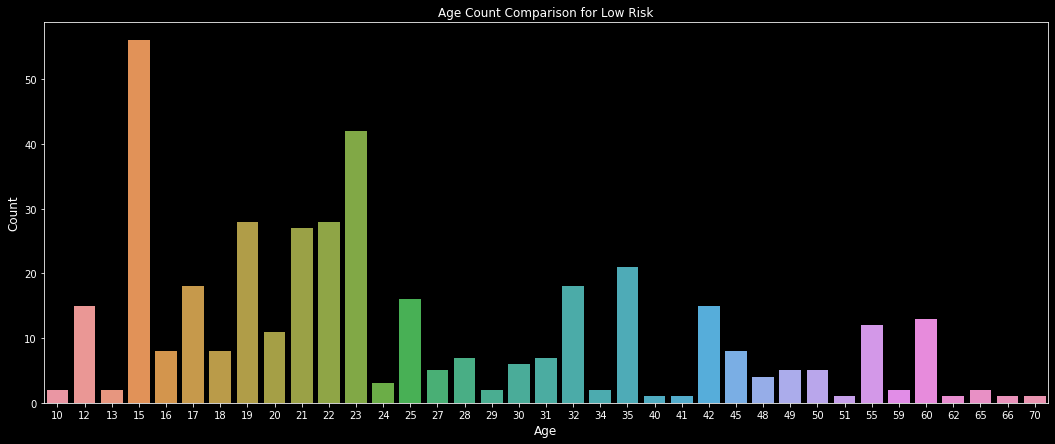

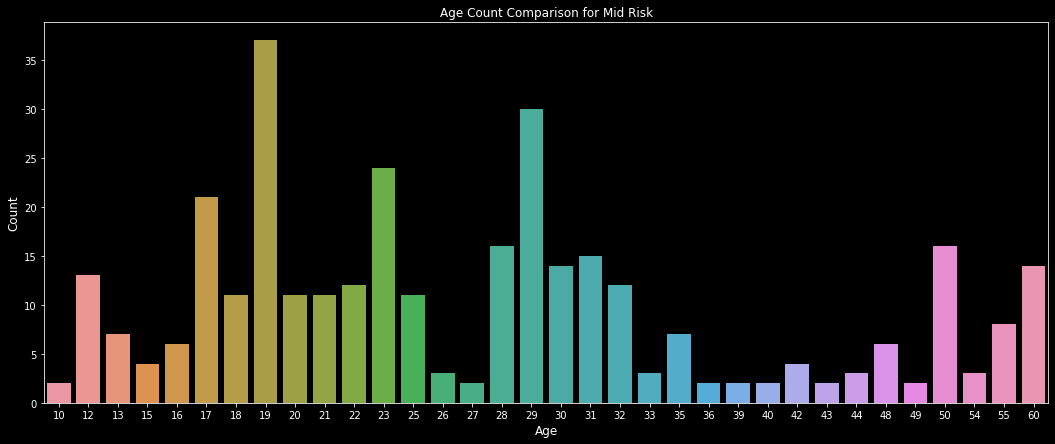

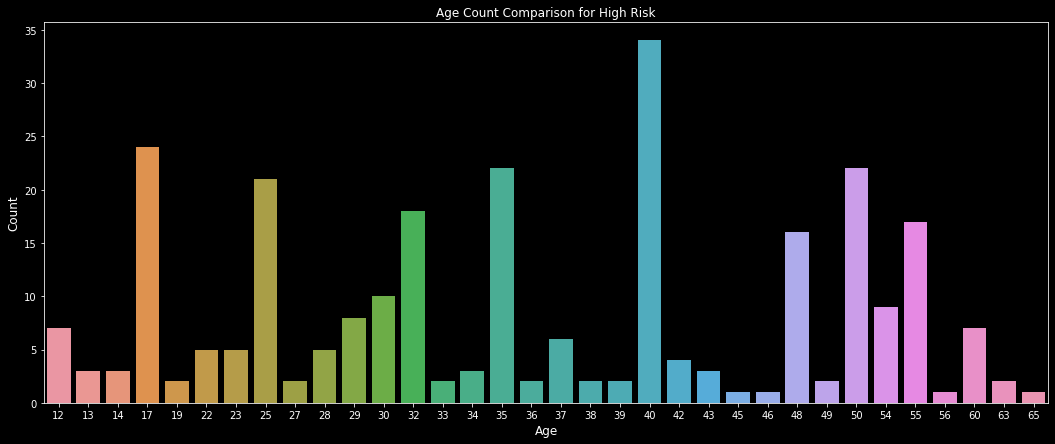

,RiskLevel,SystolicBP,Count
0,0,70,5
1,0,75,8
2,0,76,16
3,0,78,3
4,0,80,5
5,0,85,11
6,0,90,72
7,0,95,8
8,0,99,2
9,0,100,65


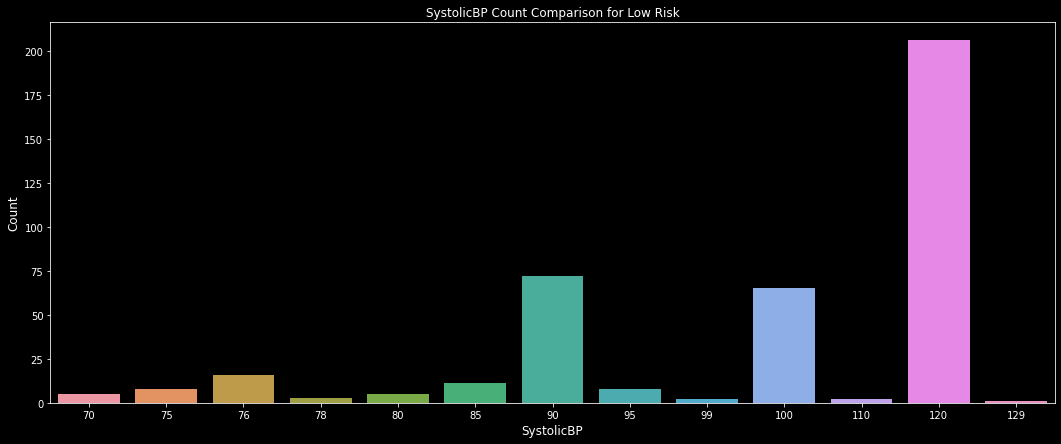

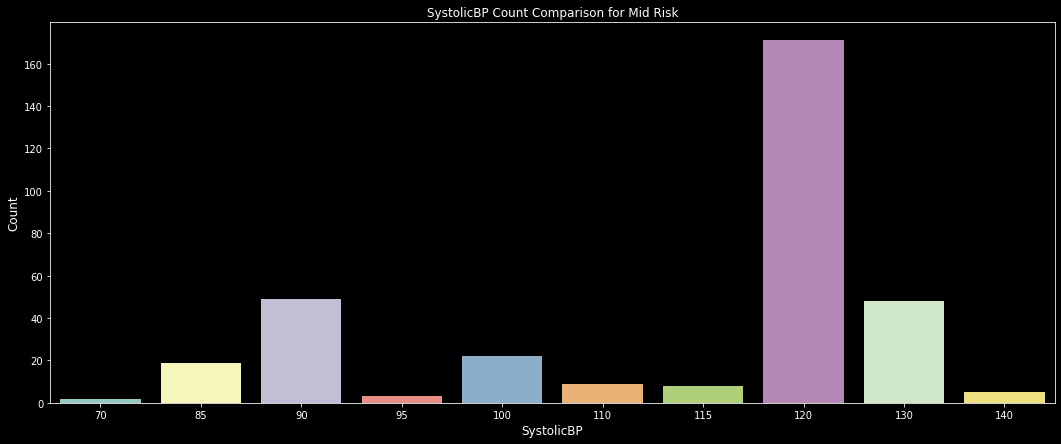

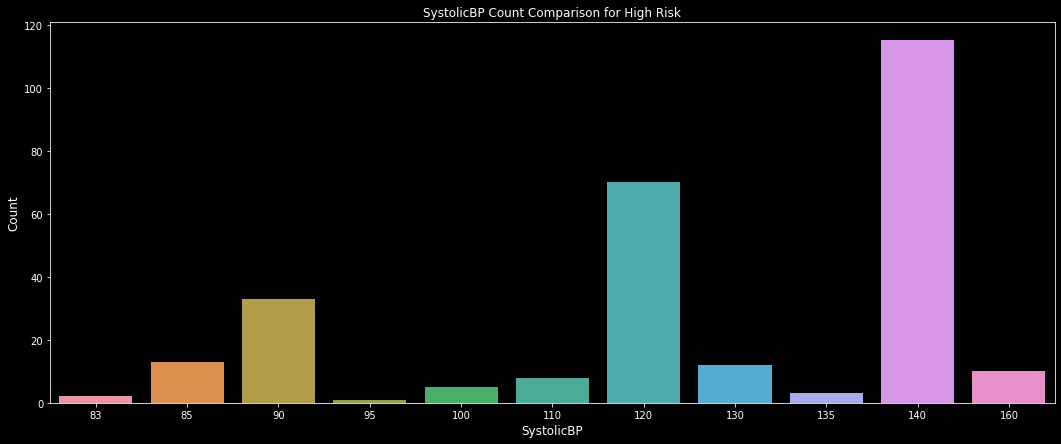

,RiskLevel,DiastolicBP,Count
0,0,49,25
1,0,50,16
2,0,60,75
3,0,63,2
4,0,65,41
5,0,68,2
6,0,70,38
7,0,75,13
8,0,76,3
9,0,80,96


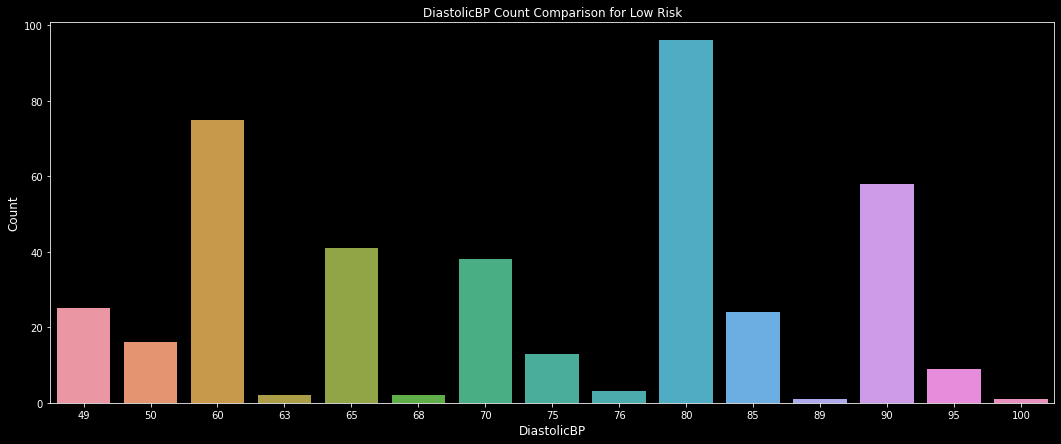

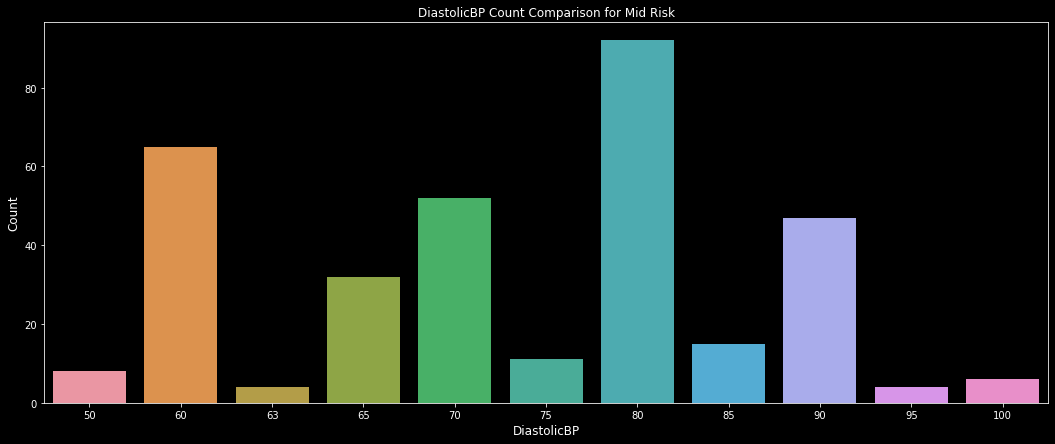

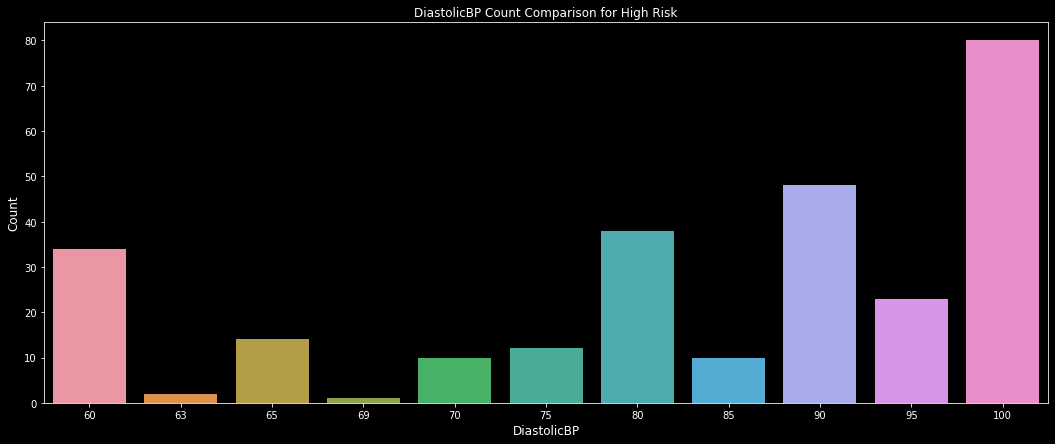

,RiskLevel,BS,Count
0,0,6.00,7
1,0,6.10,32
2,0,6.40,8
3,0,6.50,1
4,0,6.60,2
5,0,6.70,10
6,0,6.80,37
7,0,6.90,47
8,0,7.00,29
9,0,7.01,3


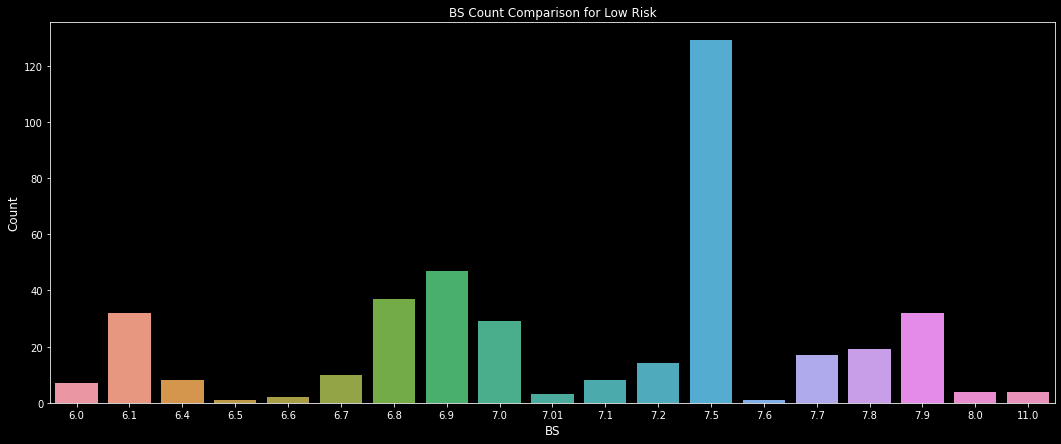

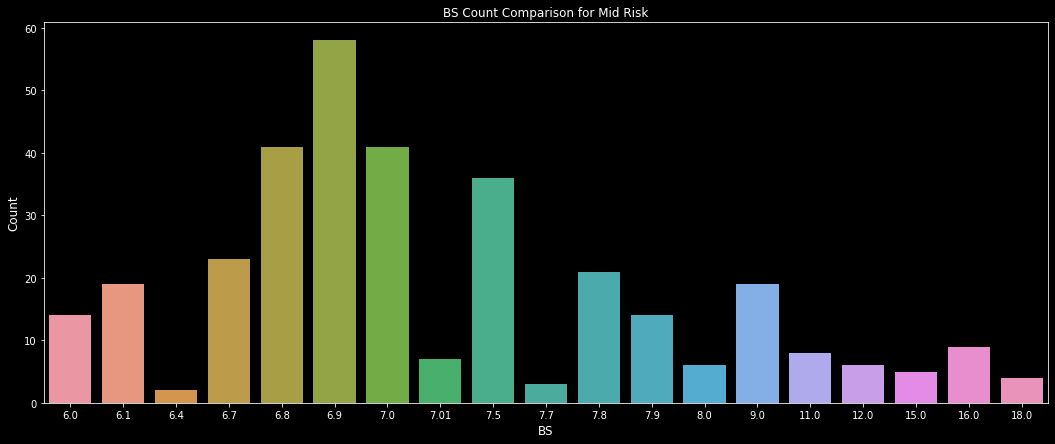

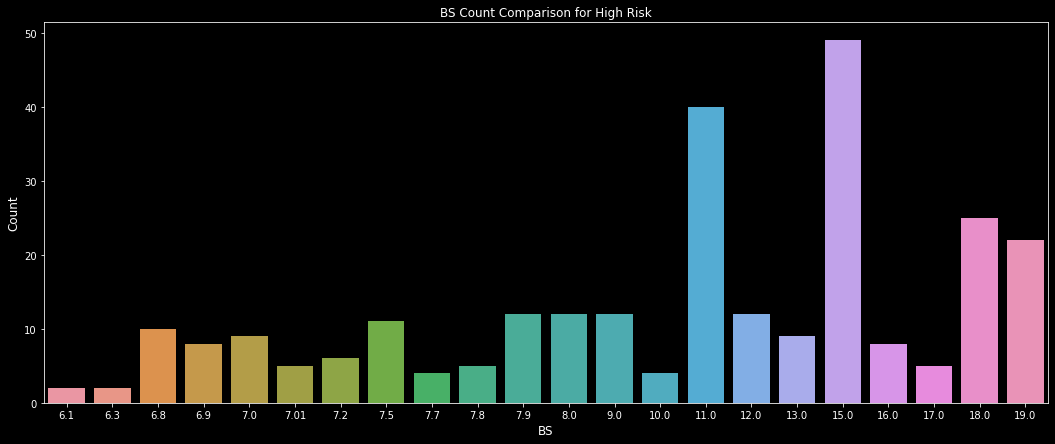

,RiskLevel,BodyTemp,Count
0,0,98.00,357
1,0,98.40,2
2,0,99.00,6
3,0,100.00,2
4,0,101.00,14
5,0,102.00,18
6,0,103.00,5
7,1,98.00,246
8,1,99.00,2
9,1,100.00,13


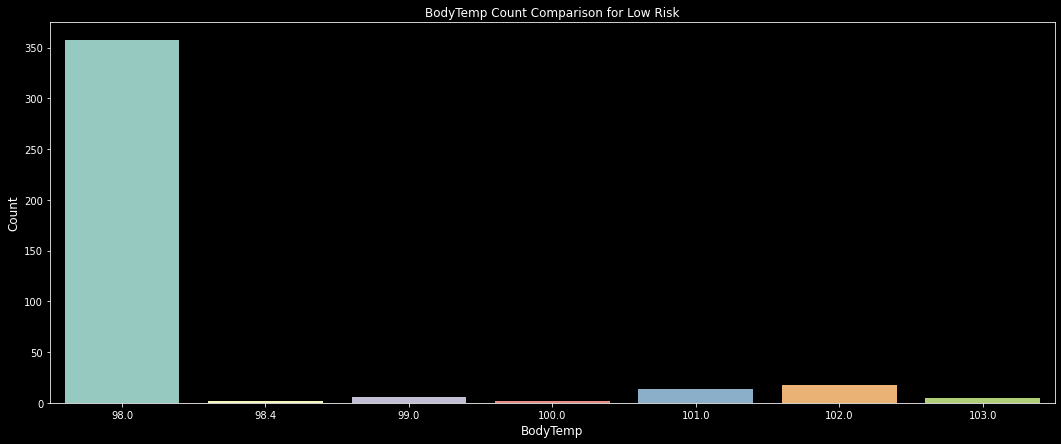

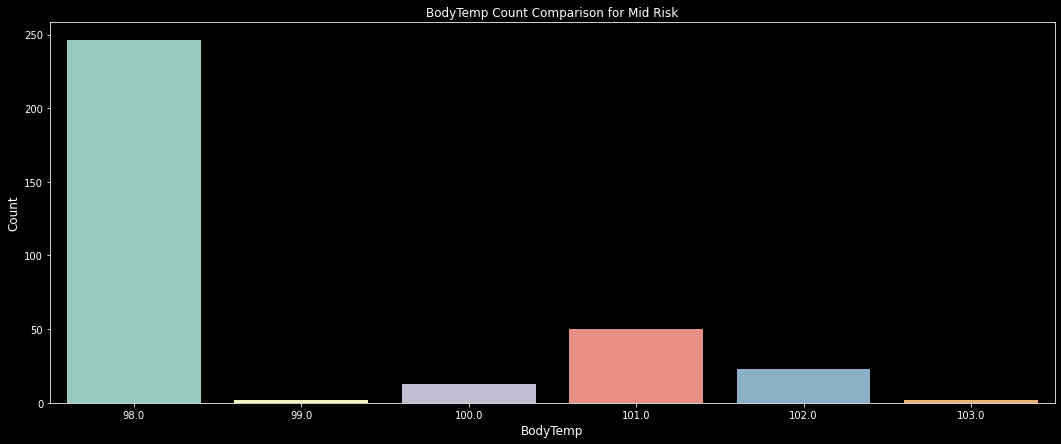

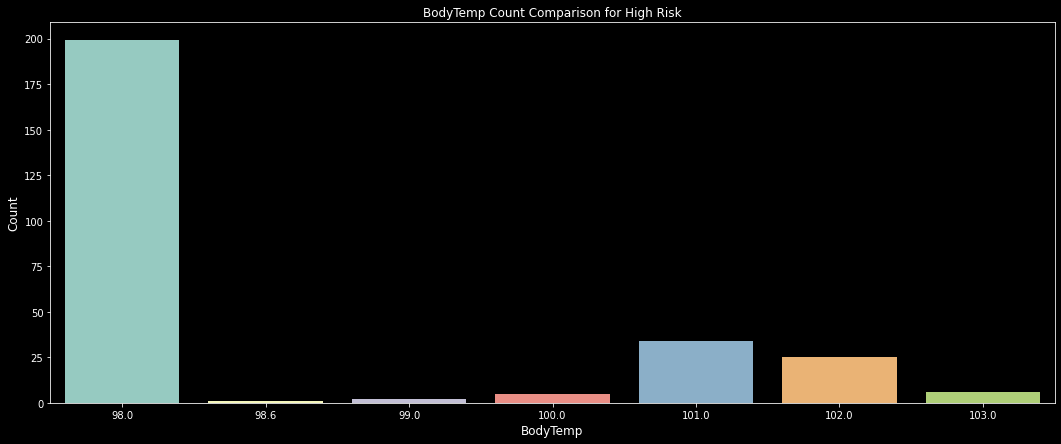

,RiskLevel,HeartRate,Count
0,0,60,33
1,0,65,2
2,0,66,44
3,0,67,2
4,0,70,126
5,0,75,7
6,0,76,55
7,0,77,56
8,0,78,2
9,0,80,39


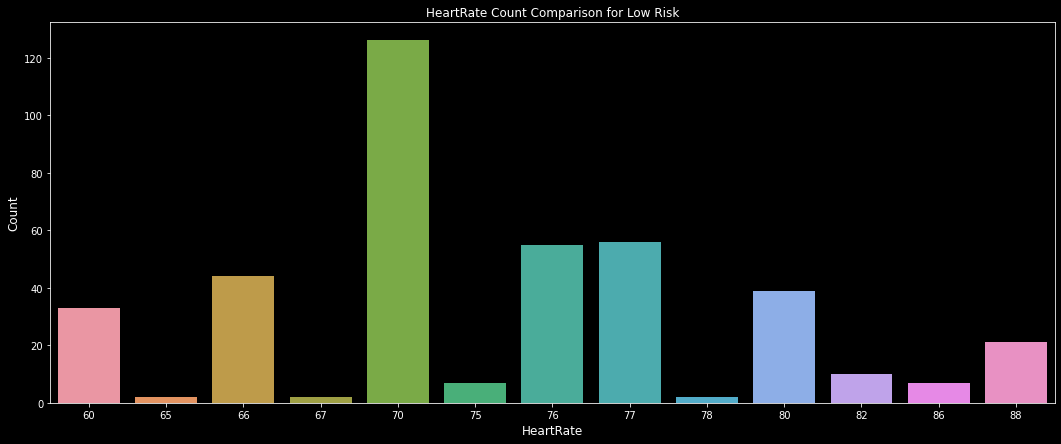

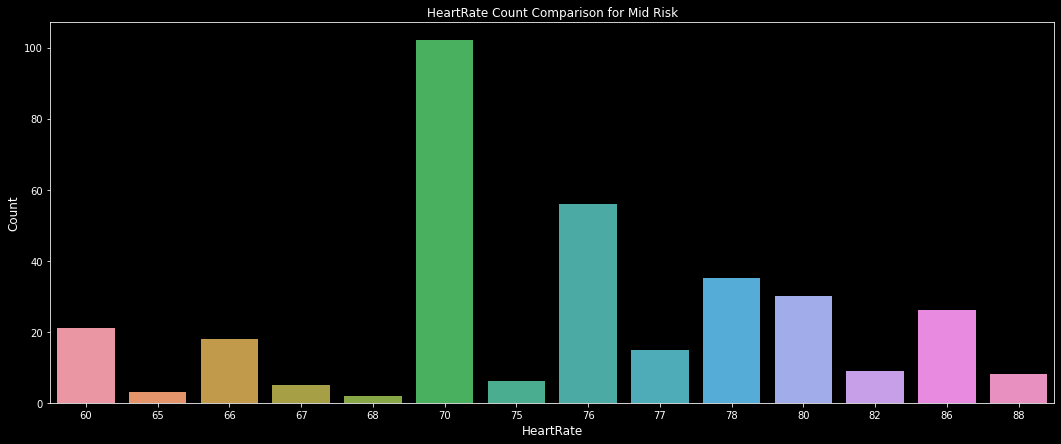

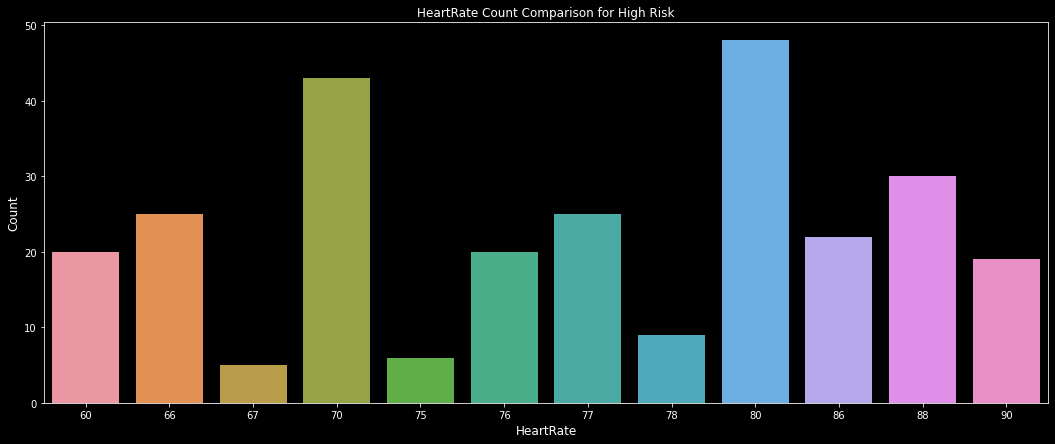

In [49]:
print(df.columns)
for col in df.columns[:-1]:
    df_plot = df.groupby([y_label, col]).size().reset_index().rename({0: "Count"}, axis=1)
    display(df_plot)
    sns.barplot(x=col, y="Count", hue=None, data=df_plot[df_plot[y_label]==0]).set_title(f"{col} Count Comparison for Low Risk")
    plt.show()
    sns.barplot(x=col, y="Count", hue=None, data=df_plot[df_plot[y_label]==1]).set_title(f"{col} Count Comparison for Mid Risk")
    plt.show()
    sns.barplot(x=col, y="Count", hue=None, data=df_plot[df_plot[y_label]==2]).set_title(f"{col} Count Comparison for High Risk")
    plt.show()

RiskLevel,0,1,2
Age,26.92,28.36,36.22
SystolicBP,105.80,113.15,124.19
DiastolicBP,72.52,74.23,85.07
BS,7.22,7.80,12.12
BodyTemp,98.37,98.83,98.90
HeartRate,73.10,74.18,76.74


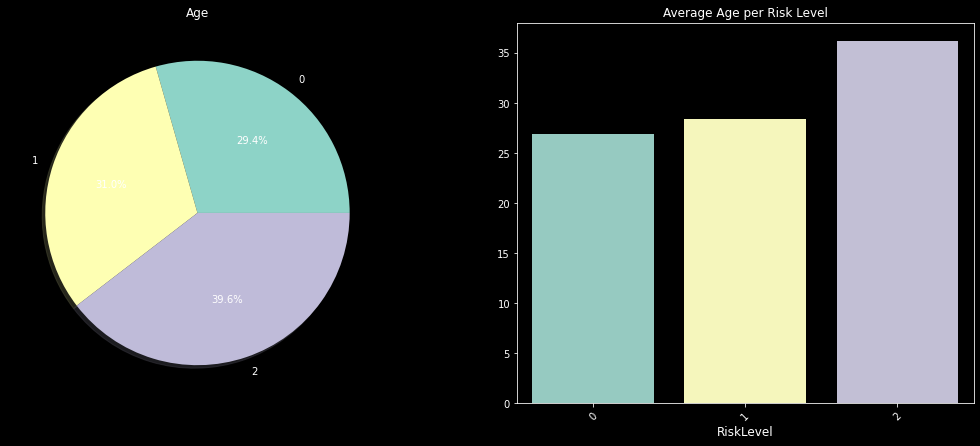

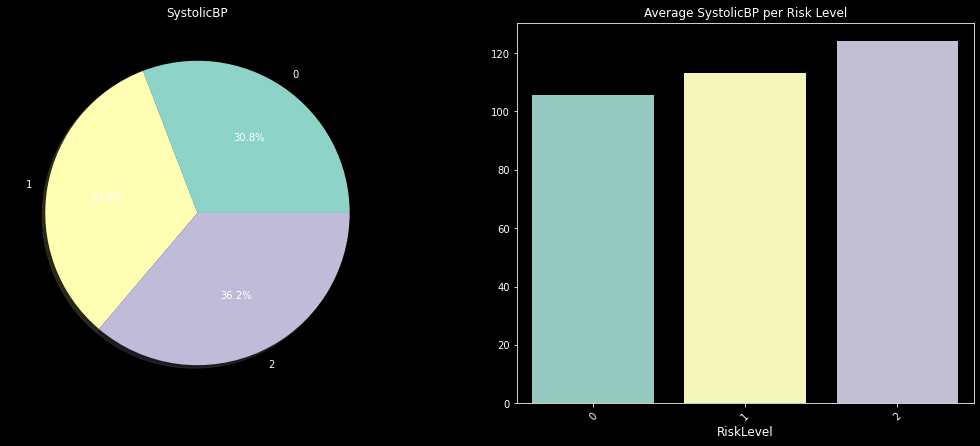

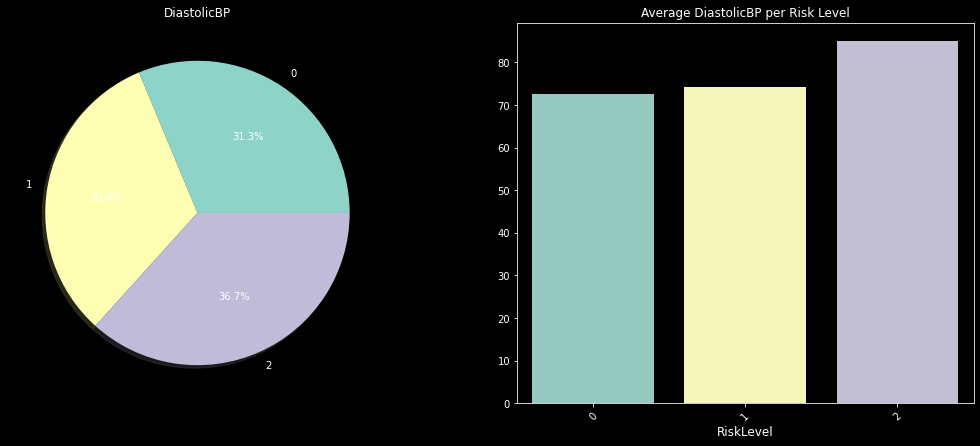

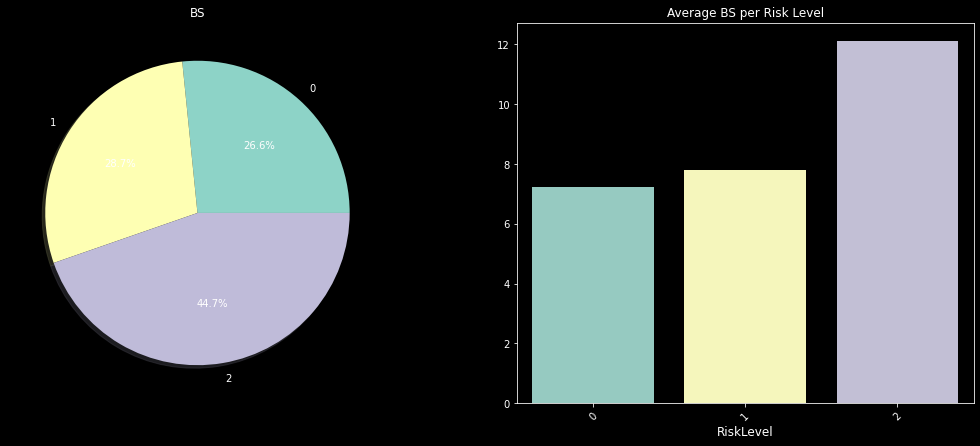

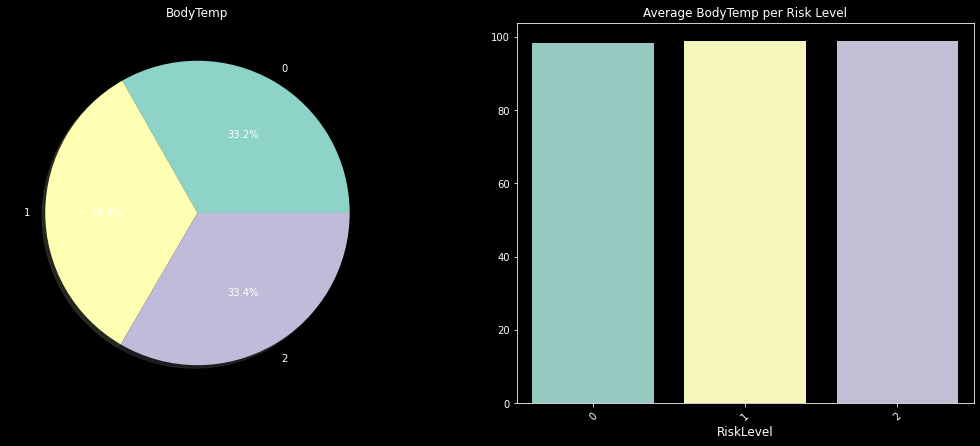

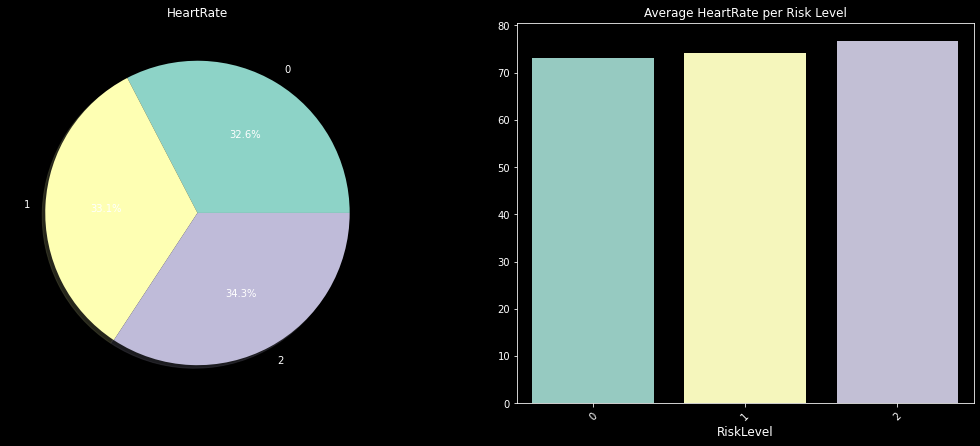

In [50]:
for col in col_cat + col_num_disc + [y_label]:
    df_plot = df.groupby([col]).mean().T.abs()
    display(df_plot)
    for topic in df_plot.index:
        df_plot_1 = df_plot.loc[topic]
        fig, ax = plt.subplots(nrows=1, ncols=2)
        ax[0].pie(x=df_plot_1.values, autopct="%.1f%%", shadow=True, labels=df_plot_1.index)
        ax[0].set_title(topic)
        sns.barplot(x=df_plot_1.index, y=df_plot_1.values, ax=ax[1]).set_title(f"Average {topic} per Risk Level")
        plt.xticks(rotation=45)
        plt.show()

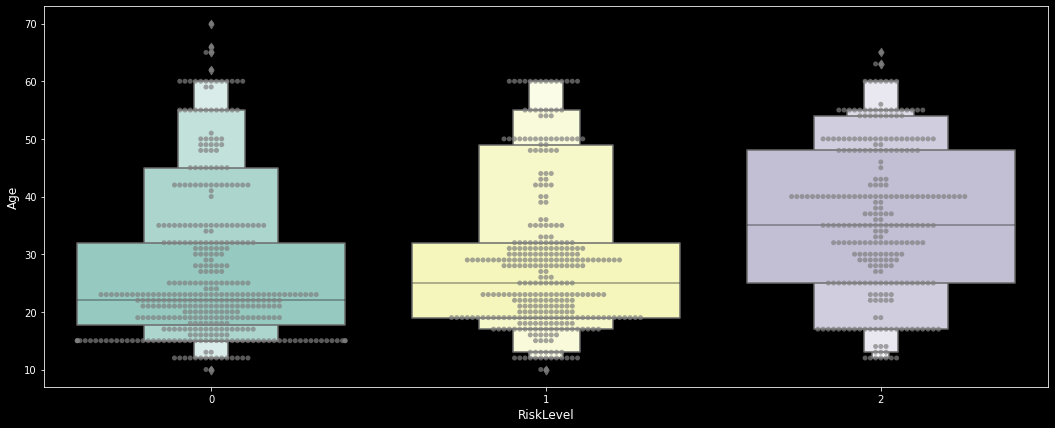

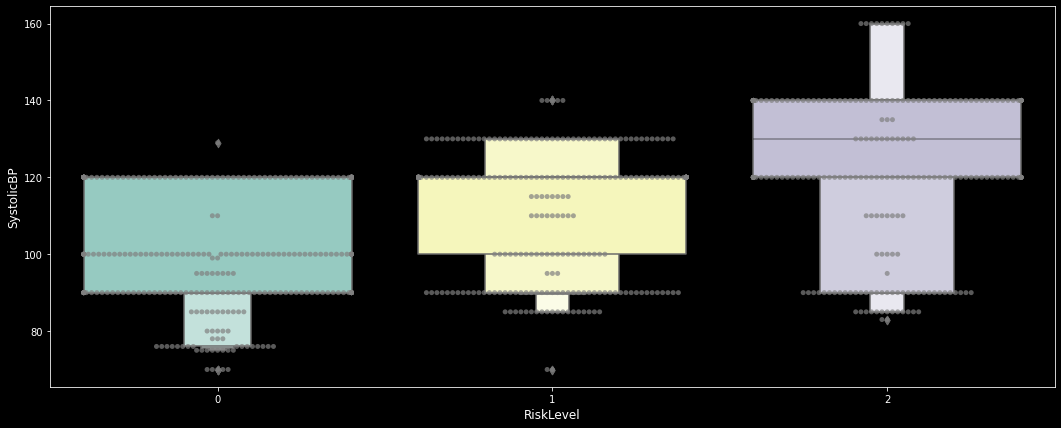

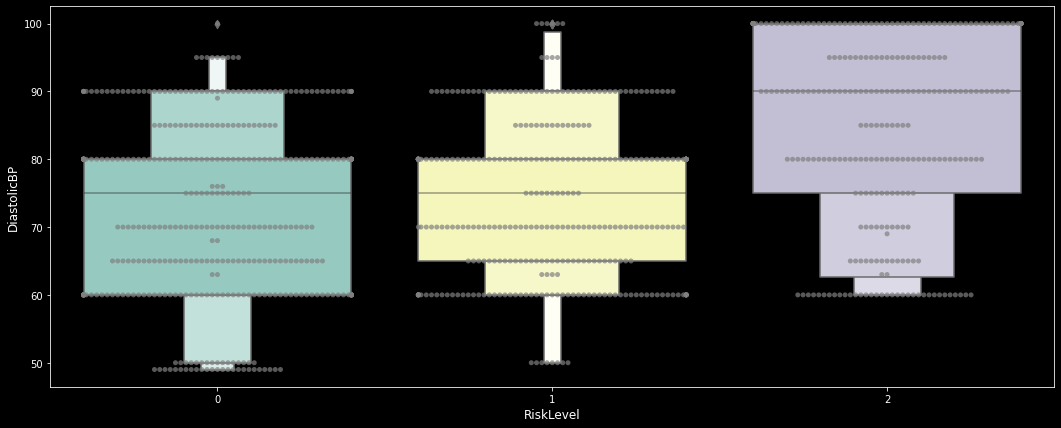

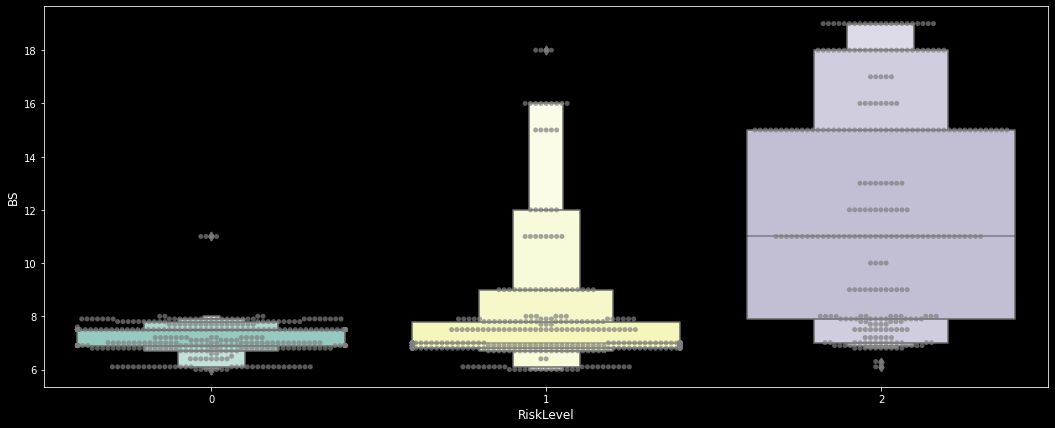

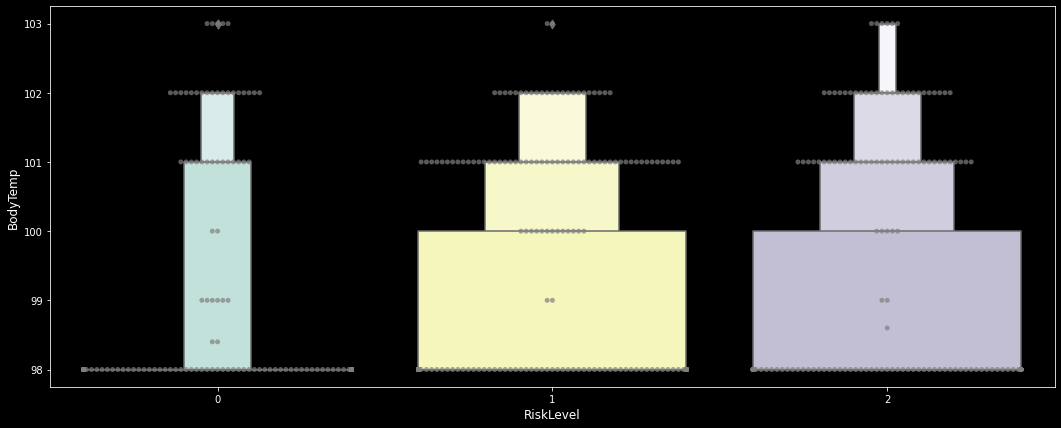

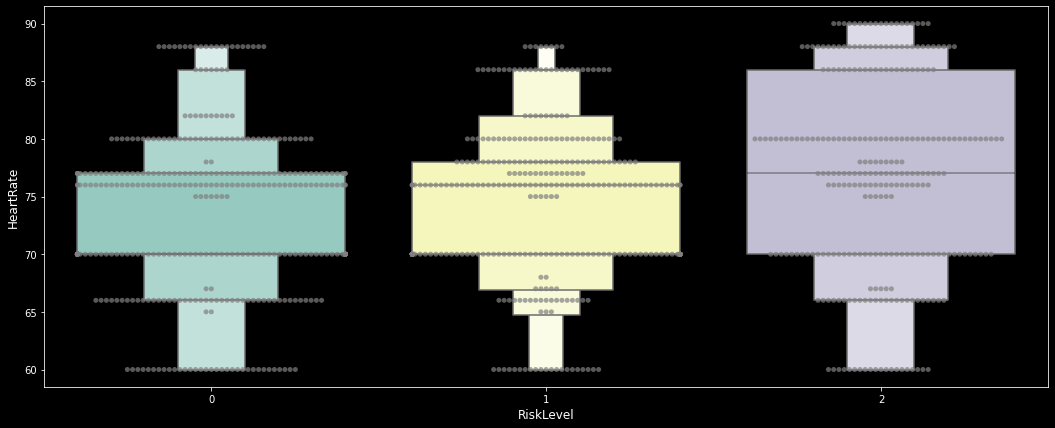

In [51]:
for col in col_num:
    if CLASSIFICATION:
        fig, ax = plt.subplots(nrows=1, ncols=1)
        sns.swarmplot(x=y_label, y=col, data=df, color="grey", alpha=0.7, ax=ax)
        sns.boxenplot(x=y_label, y=col, data=df, ax=ax)
    else:
        sns.jointplot(x=col, y=y_label, hue=None, data=df, kind="reg")
        sns.jointplot(x=col, y=y_label, hue=None, data=df, kind="hex")
    plt.show()

# Applying Boxcox transformation to BS

In [52]:
transformation_table = {
    "log": [],
    "log1p": [],
    "reciprocal": [],
    "sqrt": [],
    "exp": [],
    "boxcox": ["BS"],
    "boxcox1": [],
    "cap": [],
    "drop": [],
    "keep": df.columns.tolist(),
}
for transform, cols in transformation_table.items():
    if cols:
        col_outlier = [col for col in col_num_cont + ([] if CLASSIFICATION else [y_label]) if col in cols]
        q1, q3 = df[col_outlier].quantile(0.25), df[col_outlier].quantile(0.75)
        iqr = q3 - q1
        lower_range, upper_range = q1 - (1.5 * iqr), q3 + (1.5 * iqr)
        condition = ~((df[col_outlier] < lower_range) | (df[col_outlier] > upper_range)).any(axis=1)
        print("-------------------------------------------------------")
        print(f"Performing {transform} transformation on cols {cols}.")
        print(f"Current Shape: {df.shape}.")
        print("-------------------------------------------------------")
        print(f"Scanning for outliers in {col_outlier}.")
        print(f"Outliers Percentage: {(df.shape[0] - df[condition].shape[0]) / df.shape[0] * 100:.2f}%")
        print("-------------------------------------------------------")
        print(f"upper_range:\n{upper_range}")
        print("-------------------------------------------------------")
        print(f"lower_range:\n{lower_range}")
        print("-------------------------------------------------------")
        if transform == "keep":
            print(f"Outliers have been kept {df.shape}.")
        elif transform == "cap":
            for col in col_outlier:
                df[col] = np.where(df[col] < lower_range[col], lower_range[col], df[col])
                df[col] = np.where(df[col] > upper_range[col], upper_range[col], df[col])
            print(f"Outliers have been capped {df.shape}.")
        elif transform == "drop":
            df = df[condition]
            print(f"Outliers have been removed {df.shape}.")
        elif transform == "log":
            for col in col_outlier:
                df[col] = np.log(df[col])
            print(f"Outliers have been log transformed {df.shape}.")
        elif transform == "log1p":
            for col in col_outlier:
                df[col] = np.log1p(df[col])
            print(f"Outliers have been log1p transformed {df.shape}.")
        elif transform == "reciprocal":
            for col in col_outlier:
                df[col] = (1 / df[col])
            print(f"Outliers have been reciprocal transformed {df.shape}.")
        elif transform == "sqrt":
            for col in col_outlier:
                df[col] = (df[col] ** 0.5)
            print(f"Outliers have been sqrt transformed {df.shape}.")
        elif transform == "exp":
            for col in col_outlier:
                df[col] = (df[col] ** (1/1.2))
            print(f"Outliers have been exp transformed {df.shape}.")
        elif transform == "boxcox":
            for col in col_outlier:
                df[col] = stat.boxcox(df[col])[0]
            print(f"Outliers have been boxcox transformed {df.shape}.")
        elif transform == "boxcox1":
            for col in col_outlier:
                df[col] = stat.boxcox(df[col] + 1)[0]
            print(f"Outliers have been boxcox1 transformed {df.shape}.")
        print("\n\n")

-------------------------------------------------------
Performing boxcox transformation on cols ['BS'].
Current Shape: (1012, 7).
-------------------------------------------------------
Scanning for outliers in ['BS'].
Outliers Percentage: 20.75%
-------------------------------------------------------
upper_range:
BS   9.65
dtype: float64
-------------------------------------------------------
lower_range:
BS   5.25
dtype: float64
-------------------------------------------------------
Outliers have been boxcox transformed (1012, 7).



-------------------------------------------------------
Performing keep transformation on cols ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'RiskLevel'].
Current Shape: (1012, 7).
-------------------------------------------------------
Scanning for outliers in ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate'].
Outliers Percentage: 32.91%
-------------------------------------------------------
upper_range:
Age   

# Final feature distribution check

-------------------------------------------------------
Age
Skew: 0.78
Kurtosis: -0.39


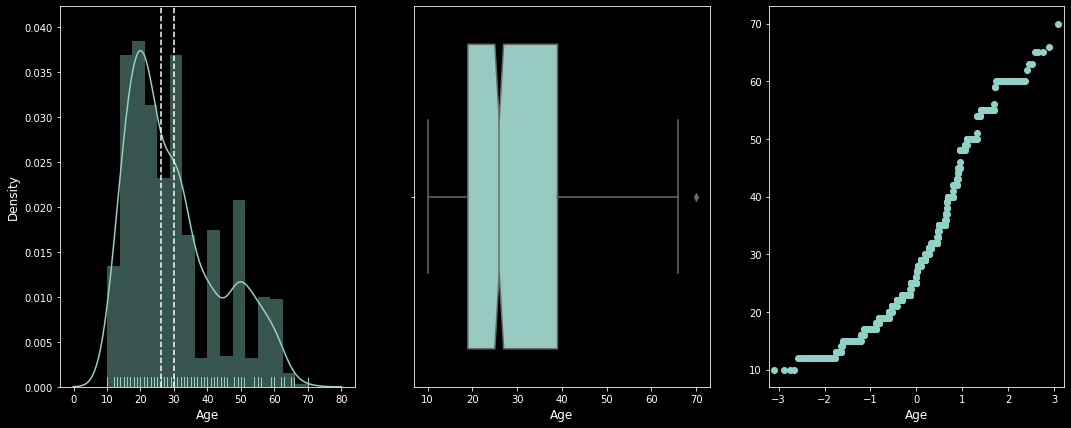

-------------------------------------------------------
SystolicBP
Skew: -0.25
Kurtosis: -0.62


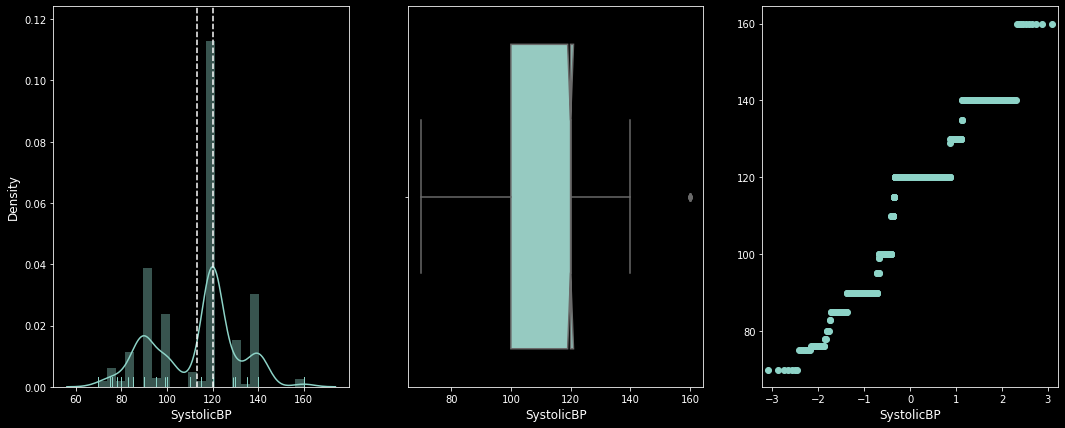

-------------------------------------------------------
DiastolicBP
Skew: -0.05
Kurtosis: -0.95


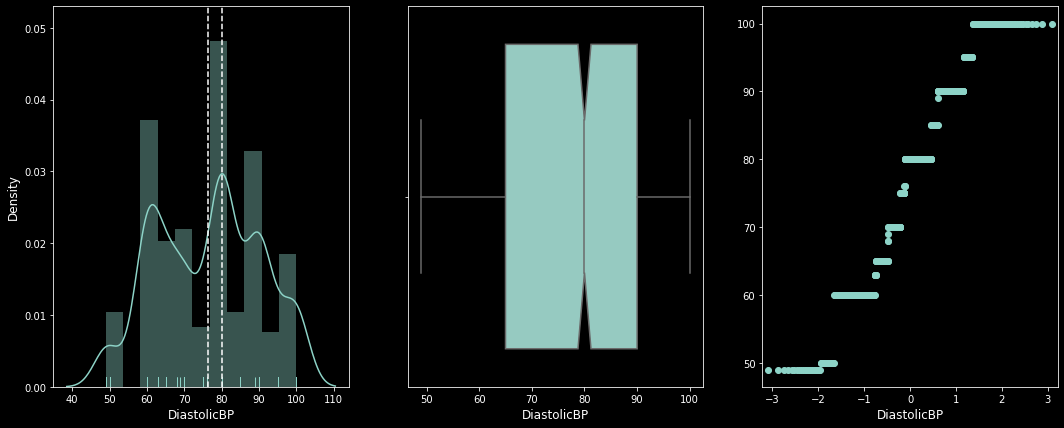

-------------------------------------------------------
BS
Skew: 0.36
Kurtosis: -0.45


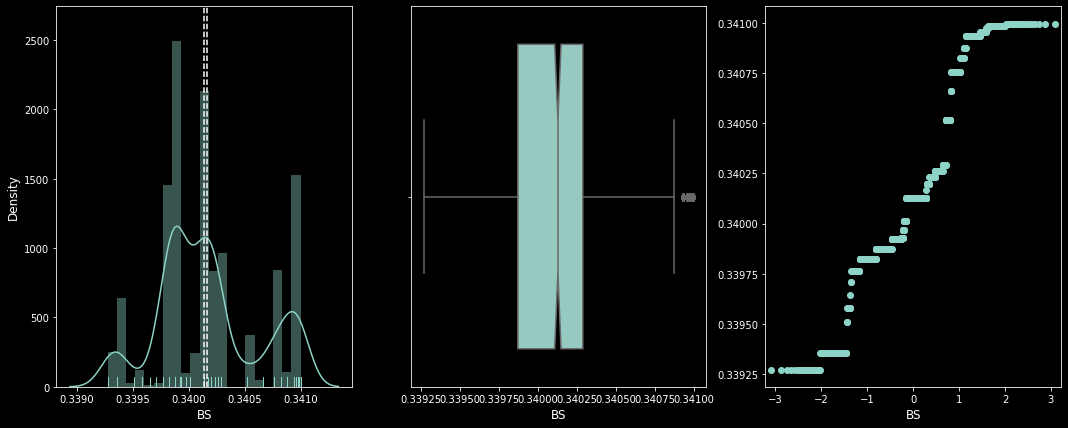

-------------------------------------------------------
BodyTemp
Skew: 1.75
Kurtosis: 1.44


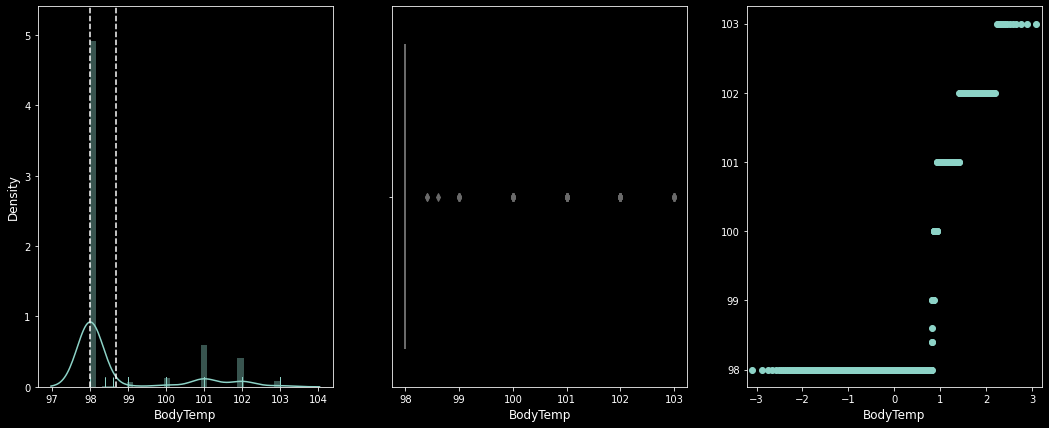

-------------------------------------------------------
HeartRate
Skew: 0.07
Kurtosis: -0.48


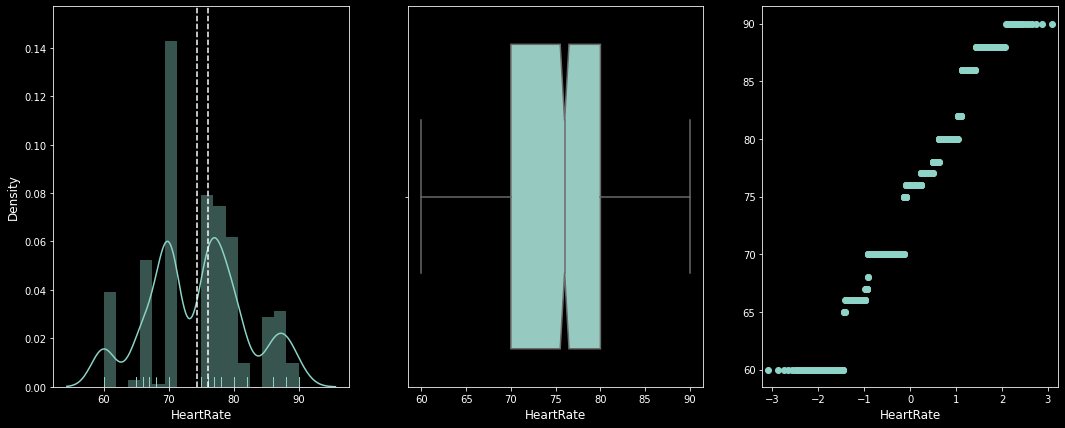

In [53]:
for col in col_num_cont + ([] if CLASSIFICATION else [y_label]):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    sns.distplot(x=df[col], ax=ax[0], rug=True).set_xlabel(f"{col}")
    sns.boxplot(x=df[col], ax=ax[1], notch=True).set_xlabel(f"{col}")
    sm.qqplot(data=df[col], ax=ax[2], xlabel=col, ylabel="")
    ax[0].axvline(x=df[col].mean(), linestyle="--")
    ax[0].axvline(x=df[col].median(), linestyle="--")
    print("-------------------------------------------------------")
    print(f"{col}\nSkew: {df[col].skew(axis=0, skipna=True):.2f}\nKurtosis: {df[col].kurtosis(axis=0, skipna=True):.2f}")
    plt.show()

# Feature engineering (impute, ohe 'if applicable', scaling, variance threshold, pca)

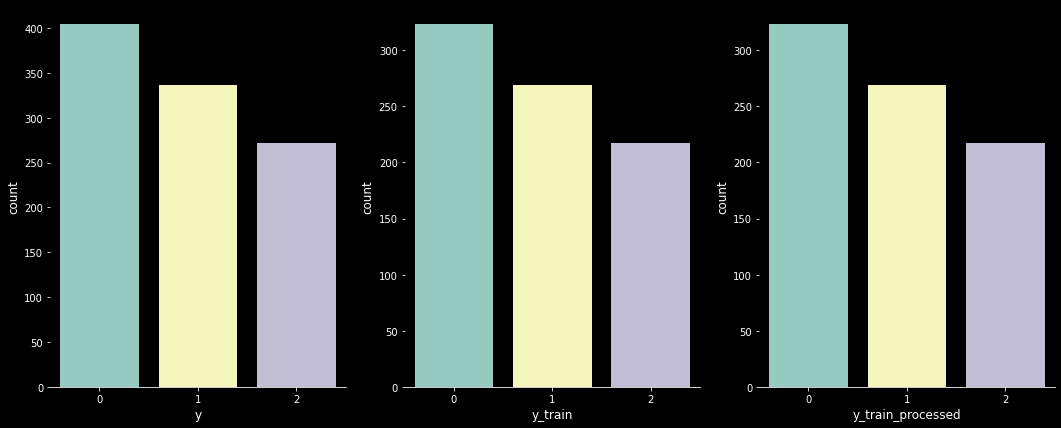

-------------------------------------------------------
class_weights: {0: 0.8348813209494325, 1: 1.0024783147459728, 2: 1.2427035330261136}
-------------------------------------------------------
y:
0   0.40
1   0.33
2   0.27
Name: RiskLevel, dtype: float64
-------------------------------------------------------
y_train:
0   0.40
1   0.33
2   0.27
Name: RiskLevel, dtype: float64
-------------------------------------------------------
y_train_processed:
0   0.40
1   0.33
2   0.27
Name: RiskLevel, dtype: float64
-------------------------------------------------------
y_test:
0   0.40
1   0.33
2   0.27
Name: RiskLevel, dtype: float64
-------------------------------------------------------
y_test_processed:
0   0.40
1   0.33
2   0.27
Name: RiskLevel, dtype: float64
-------------------------------------------------------
col_cat_oe (0): []
col_cat_ohe (0): []
col_num_disc (0): []
col_num_cont (6): ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
-------------------------

In [54]:
X, y = df.drop(y_label, axis=1), df[y_label]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=[None, y, y][CLASSIFICATION],
    random_state=RANDOM_STATE,
)
preprocessor_cat_ohe = make_pipeline(
    (SimpleImputer(strategy="most_frequent")),
    (OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False)),
)
preprocessor_num_disc = make_pipeline(
    (KNNImputer(n_neighbors=5)),
)
preprocessor_num_cont = make_pipeline(
    (KNNImputer(n_neighbors=5)),
)
preprocessor_col = make_column_transformer(
    (preprocessor_cat_oe, col_cat_oe),
    (preprocessor_cat_ohe, col_cat_ohe),
    (preprocessor_num_disc, col_num_disc),
    (preprocessor_num_cont, col_num_cont),
    sparse_threshold=0
)
preprocessor = make_pipeline(
    (preprocessor_col),
    ([MinMaxScaler(), StandardScaler()][SCALER]),
    (VarianceThreshold(threshold=0)),
    (PCA())
)
X_train_processed, y_train_processed = preprocessor.fit_transform(X_train), y_train
X_test_processed, y_test_processed = preprocessor.transform(X_test), y_test
if CLASSIFICATION:
    class_weights = {i: w for i, w in enumerate(class_weight.compute_class_weight(class_weight="balanced", classes=np.unique(y_train_processed), y=y_train_processed))}
    fig, ax = plt.subplots(nrows=1, ncols=3)
    sns.despine(left=True)
    sns.countplot(y, ax=ax[0]).set_xlabel("y")
    sns.countplot(y_train, ax=ax[1]).set_xlabel("y_train")
    sns.countplot(y_train_processed, ax=ax[2]).set_xlabel("y_train_processed")
    plt.show()
    print("-------------------------------------------------------")
    print(f"class_weights: {class_weights}")
    print("-------------------------------------------------------")
    print(f"y:\n{y.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_train:\n{y_train.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_train_processed:\n{y_train_processed.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_test:\n{y_test.value_counts(normalize=True)}")
    print("-------------------------------------------------------")
    print(f"y_test_processed:\n{y_test_processed.value_counts(normalize=True)}")
print("-------------------------------------------------------")
print(f"col_cat_oe ({len(col_cat_oe)}): {col_cat_oe}")
print(f"col_cat_ohe ({len(col_cat_ohe)}): {col_cat_ohe}")
print(f"col_num_disc ({len(col_num_disc)}): {col_num_disc}")
print(f"col_num_cont ({len(col_num_cont)}): {col_num_cont}")
print("-------------------------------------------------------")
print(f"total cols for preprocessor: {len(col_cat_oe) + len(col_cat_ohe) + len(col_num_disc) + len(col_num_cont)}")
print("-------------------------------------------------------")
print(f"X: {X.shape}\tX_train: {X_train.shape}\tX_train_processed:{X_train_processed.shape}\tX_test: {X_test.shape}\t\tX_test_processed:{X_test_processed.shape}")
print(f"y: {y.shape}\ty_train: {y_train.shape}\t\ty_train_processed:{y_train_processed.shape}\ty_test: {y_test.shape}\t\ty_test_processed:{y_test_processed.shape}")
print("-------------------------------------------------------")

# Building, Hyper-param Tuning ML and ANN models

In [55]:
def build_auto_model():
    if CLASSIFICATION:
        SimpleClassifier(random_state=RANDOM_STATE).fit(clean(df), target_col=y_label)
    else:
        SimpleRegressor(random_state=RANDOM_STATE).fit(clean(df), target_col=y_label)


def build_ml_model():
    tests = [
        {
            "model": make_pipeline_imb(
                preprocessor_col,
                [MinMaxScaler(), StandardScaler()][SCALER],
                SMOTE(random_state=RANDOM_STATE),
                VarianceThreshold(threshold=0),
                PCA(),
                SelectPercentile(),
                XGBClassifier() if CLASSIFICATION else XGBRegressor(),
            )
            if OVERSAMPLE
            else make_pipeline_imb(
                preprocessor_col,
                [MinMaxScaler(), StandardScaler()][SCALER],
                VarianceThreshold(threshold=0),
                PCA(),
                SelectPercentile(),
                XGBClassifier() if CLASSIFICATION else XGBRegressor(),
            ),
            "params": {
                "columntransformer__pipeline-3__knnimputer__n_neighbors": [1, 3, 5, 7, 9],
                "columntransformer__pipeline-4__knnimputer__n_neighbors": [1, 3, 5, 7, 9],
                "selectpercentile__percentile": [i * 10 for i in range(1, 10)],
                "selectpercentile__score_func": [chi2, f_classif],
                "xgbclassifier__colsample_bytree": [0.3, 0.4, 0.5, 0.7],
                "xgbclassifier__gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
                "xgbclassifier__learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
                "xgbclassifier__max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
                "xgbclassifier__min_child_weight": [1, 3, 5, 7],
            }
            if CLASSIFICATION
            else {
                "columntransformer__pipeline-3__knnimputer__n_neighbors": [1, 3, 5, 7, 9],
                "columntransformer__pipeline-4__knnimputer__n_neighbors": [1, 3, 5, 7, 9],
                "selectpercentile__percentile": [i * 10 for i in range(1, 10)],
                "selectpercentile__score_func": [chi2, f_classif],
                "xgbregressor__colsample_bytree": [0.3, 0.4, 0.5, 0.7],
                "xgbregressor__gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
                "xgbregressor__learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
                "xgbregressor__max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
                "xgbregressor__min_child_weight": [1, 3, 5, 7],
            },
        },
    ]
    for test in tests:
        rscv = RandomizedSearchCV(
            estimator=test["model"],
            param_distributions=test["params"],
            n_jobs=-1,
            cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
            if CLASSIFICATION
            else 10,
            scoring="accuracy" if CLASSIFICATION else "r2",
            n_iter=10,
            return_train_score=True,
        )
        display(rscv)
        rscv.fit(X_train, y_train)
        print("===train============================")
        print(f"{rscv.best_score_ * 100:.2f}%\n{test['model'][-1]}\n{rscv.best_params_}")
        print("===params============================")
        display(pd.DataFrame(rscv.cv_results_).sort_values(by="rank_test_score"))
        print("===test============================")
        print(f"test score:{rscv.score(X_test, y_test) * 100:.2f}%")
        print("====end===========================\n")

    build_auto_model()
    print("-------------------------------------------------------")
    if CLASSIFICATION:
        classification_report_test = classification_report(
            y_test,
            rscv.predict(X_test),
            output_dict=True,
        )
        print(f"accuracy: {classification_report_test['accuracy']:.3f} recall_macro: {classification_report_test['macro avg']['recall']:.3f} precision_macro: {classification_report_test['macro avg']['precision']:.3f} f1_macro: {classification_report_test['macro avg']['f1-score']:.3f} (Test)")
        classification_report_train = classification_report(
            y_train,
            rscv.predict(X_train),
            output_dict=True,
        )
        print(f"accuracy: {classification_report_train['accuracy']:.3f} recall_macro: {classification_report_train['macro avg']['recall']:.3f} precision_macro: {classification_report_train['macro avg']['precision']:.3f} f1_macro: {classification_report_train['macro avg']['f1-score']:.3f} (Train)")
        print("-------------------------------------------------------")
        print(
            classification_report(
                y_test,
                rscv.predict(X_test),
            )
        )
        sns.heatmap(
            tf.math.confusion_matrix(
                y_test,
                rscv.predict(X_test),
            ),
            cmap="Blues",
            fmt="d",
            annot=True,
            linewidths=1,
        )
        plt.xlabel("Predicted")
        plt.ylabel("Truth")

    else:
        print(f"r2: {r2_score(y_test, rscv.predict(X_test)):.3f} neg_mean_squared_error: -{mean_squared_error(y_test, rscv.predict(X_test)):_.3f} (Test)")
        print(f"r2: {r2_score(y_train, rscv.predict(X_train)):.3f} neg_mean_squared_error: -{mean_squared_error(y_train, rscv.predict(X_train)):_.3f} (Train)")
        print("-------------------------------------------------------")
        plt.subplot(1, 3, 1)
        sns.regplot(y_train, y_train, color="darkorange", label="Truth")
        sns.regplot(
            y_test,
            rscv.predict(X_test),
            color="darkcyan",
            label="Predicted",
        )
        plt.title(
            "Truth vs Predicted",
            fontsize=10,
        )
        plt.xlabel("Truth values")
        plt.ylabel("Predicted values")
        plt.legend()
        plt.grid()

        plt.subplot(1, 3, 2)
        sns.scatterplot(
            data=pd.DataFrame(
                {
                    "Predicted values": rscv.predict(X_train),
                    "Residuals": rscv.predict(X_train) - y_train,
                }
            ),
            x="Predicted values",
            y="Residuals",
            color="darkorange",
            marker="o",
            s=35,
            alpha=0.5,
            label="Train data",
        )
        sns.scatterplot(
            data=pd.DataFrame(
                {
                    "Predicted values": rscv.predict(X_test),
                    "Residuals": rscv.predict(X_test) - y_test,
                }
            ),
            x="Predicted values",
            y="Residuals",
            color="darkcyan",
            marker="o",
            s=35,
            alpha=0.7,
            label="Test data",
        )
        plt.title(
            "Predicted vs Residuals",
            fontsize=10,
        )
        plt.hlines(y=0, xmin=0, xmax=df[y_label].max(), lw=2, color="red")
        plt.grid()

        plt.subplot(1, 3, 3)
        sns.distplot((y_train - rscv.predict(X_train)))
        plt.title("Error Terms")
        plt.xlabel("Errors")
        plt.grid()

    plt.show()

    display(
        pd.DataFrame(
            {
                "Truth": y_test[:10].values,
                "Predicted": rscv.predict(X_test[:10]).round(1),
            }
        )
    )


def tune_dl_model(hp):
    model = keras.models.Sequential()
    model.add(
        keras.layers.Dense(
            units=hp.Int("input_00_unit", min_value=32, max_value=512, step=32),
            input_shape=X_train_processed.shape[1:],
        )
    )
    for i in range(hp.Int("num_layers", min_value=1, max_value=64)):
        model.add(
            keras.layers.Dense(
                units=hp.Int(f"hidden_{i:02}_unit", min_value=32, max_value=512, step=32),
                activation="relu",
            )
        )
        model.add(keras.layers.Dropout(hp.Float("dropout", min_value=0, max_value=0.5, step=0.1)))
    model.add(
        keras.layers.Dense(
            units=[1, 1, df[y_label].nunique()][CLASSIFICATION],
            activation=["linear", "sigmoid", "softmax"][CLASSIFICATION],
        )
    )
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        ),
        loss=["mean_squared_error", "binary_crossentropy", "sparse_categorical_crossentropy"][CLASSIFICATION],
        metrics=["mean_squared_error", "accuracy", "accuracy"][CLASSIFICATION],
    )
    return model


def train_dl_model():
    tuner.search(
        X_train_processed,
        y_train_processed,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        callbacks=[early_stop],
        epochs=MAX_TRIALS,
        validation_split=0.2,
        verbose=1,
    )
    tuner.results_summary()

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(
        X_train_processed,
        y_train_processed,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        epochs=EPOCHS,
        validation_split=0.2,
        verbose=1,
        class_weight=class_weights if OVERSAMPLE else None
    )
    val_per_epoch = history.history[
        ["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION]
    ]
    best_epoch = val_per_epoch.index([min(val_per_epoch), max(val_per_epoch), max(val_per_epoch)][CLASSIFICATION]) + 1

    plt.subplot(1, 2, 1)
    sns.lineplot(data=history.history[["mean_squared_error", "accuracy", "accuracy"][CLASSIFICATION]], color="deeppink", linewidth=2.5)
    sns.lineplot(data=history.history[["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION]], color="darkturquoise", linewidth=2.5)
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Training Accuracy", "Val Accuracy"], loc="lower right")
    plt.grid()

    plt.subplot(1, 2, 2)
    sns.lineplot(data=history.history["loss"], color="deeppink", linewidth=2.5)
    sns.lineplot(data=history.history["val_loss"], color="darkturquoise", linewidth=2.5)
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Training Loss", "Val Loss"], loc="upper right")
    plt.grid()
    plt.show()

    print(f"Best epoch: {best_epoch}")
    
    return best_epoch, best_hps


def build_dl_model(best_epoch, best_hps):
    model = tuner.hypermodel.build(best_hps)
    model.fit(
        X_train_processed,
        y_train_processed,
        batch_size=256 if tf.config.list_physical_devices("GPU") else 64,
        epochs=best_epoch,
        validation_split=0.2,
        verbose=1,
        class_weight=class_weights if OVERSAMPLE else None
    )
    build_auto_model()
    print("-------------------------------------------------------")
    if CLASSIFICATION:
        classification_report_test = classification_report(
            y_test_processed,
            [
                model.predict(X_test_processed).round(),
                np.argmax(model.predict(X_test_processed), axis=1),
            ][CLASSIFICATION - 1],
            output_dict=True,
        )
        print(f"accuracy: {classification_report_test['accuracy']:.3f} recall_macro: {classification_report_test['macro avg']['recall']:.3f} precision_macro: {classification_report_test['macro avg']['precision']:.3f} f1_macro: {classification_report_test['macro avg']['f1-score']:.3f} (Test)")
        classification_report_train = classification_report(
            y_train_processed,
            [
                model.predict(X_train_processed).round(),
                np.argmax(model.predict(X_train_processed), axis=1),
            ][CLASSIFICATION - 1],
            output_dict=True,
        )
        print(f"accuracy: {classification_report_train['accuracy']:.3f} recall_macro: {classification_report_train['macro avg']['recall']:.3f} precision_macro: {classification_report_train['macro avg']['precision']:.3f} f1_macro: {classification_report_train['macro avg']['f1-score']:.3f} (Train)")
        print("-------------------------------------------------------")
        print(
            classification_report(
                y_test_processed,
                [
                    model.predict(X_test_processed).round(),
                    np.argmax(model.predict(X_test_processed), axis=1),
                ][CLASSIFICATION - 1],
            )
        )
        sns.heatmap(
            tf.math.confusion_matrix(
                y_test_processed,
                [
                    model.predict(X_test_processed).round(),
                    np.argmax(model.predict(X_test_processed), axis=1),
                ][CLASSIFICATION - 1],
            ),
            cmap="Blues",
            fmt="d",
            annot=True,
            linewidths=1,
        )
        plt.xlabel("Predicted")
        plt.ylabel("Truth")

    else:
        print(f"r2: {r2_score(y_test_processed, model.predict(X_test_processed).T[0]):.3f} neg_mean_squared_error: -{mean_squared_error(y_test_processed, model.predict(X_test_processed)):_.3f} (Test)")
        print(f"r2: {r2_score(y_train_processed, model.predict(X_train_processed).T[0]):.3f} neg_mean_squared_error: -{mean_squared_error(y_train_processed, model.predict(X_train_processed)):_.3f} (Train)")
        print("-------------------------------------------------------")
        plt.subplot(1, 3, 1)
        sns.regplot(y_train_processed, y_train_processed, color="darkorange", label="Truth")
        sns.regplot(
            y_test_processed,
            model.predict(X_test_processed).T[0],
            color="darkcyan",
            label="Predicted",
        )
        plt.title(
            "Truth vs Predicted",
            fontsize=10,
        )
        plt.xlabel("Truth values")
        plt.ylabel("Predicted values")
        plt.legend()
        plt.grid()

        plt.subplot(1, 3, 2)
        sns.scatterplot(
            data=pd.DataFrame(
                {
                    "Predicted values": model.predict(X_train_processed).T[0],
                    "Residuals": model.predict(X_train_processed).T[0] - y_train_processed,
                }
            ),
            x="Predicted values",
            y="Residuals",
            color="darkorange",
            marker="o",
            s=35,
            alpha=0.5,
            label="Train data",
        )
        sns.scatterplot(
            data=pd.DataFrame(
                {
                    "Predicted values": model.predict(X_test_processed).T[0],
                    "Residuals": model.predict(X_test_processed).T[0] - y_test_processed,
                }
            ),
            x="Predicted values",
            y="Residuals",
            color="darkcyan",
            marker="o",
            s=35,
            alpha=0.7,
            label="Test data",
        )
        plt.title(
            "Predicted vs Residuals",
            fontsize=10,
        )
        plt.hlines(y=0, xmin=0, xmax=df[y_label].max(), lw=2, color="red")
        plt.grid()
        
        plt.subplot(1, 3, 3)
        sns.distplot((y_train_processed - model.predict(X_train_processed).T[0]))
        plt.title("Error Terms")
        plt.xlabel("Errors")
        plt.grid()

    plt.show()

    display(
        pd.DataFrame(
            {
                "Truth": y_test_processed[:10].values,
                "Predicted": [
                    model.predict(X_test_processed[:10]).T[0],
                    model.predict(X_test_processed[:10]).T[0].round(),
                    np.argmax(model.predict(X_test_processed[:10]), axis=1),
                ][CLASSIFICATION],
            }
        )
    )
    return model


if SEARCH == "hyperband":
    tuner = Hyperband(
        tune_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_epochs=MAX_TRIALS,
        factor=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
elif SEARCH == "random":
    tuner = RandomSearch(
        tune_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )
else:
    tuner = BayesianOptimization(
        tune_dl_model,
        objective=["val_mean_squared_error", "val_accuracy", "val_accuracy"][CLASSIFICATION],
        max_trials=MAX_TRIALS,
        executions_per_trial=3,
        directory=".",
        project_name="keras_tuner",
        overwrite=True,
    )

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=int(MAX_TRIALS/4))
tuner.search_space_summary()

Search space summary
Default search space size: 5
input_00_unit (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 64, 'step': 1, 'sampling': None}
hidden_00_unit (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


# Building ML model with SMOTE

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=11, shuffle=True),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('columntransformer',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0,
                                                                transformer_weights=None,
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('simpleimputer',
                                                                                                SimpleImputer(add_indicator=Fal...
                                        'xgbclassifier__colsample_bytree': [0.3,
                                                                            0.4,
                                                                            0.5,
                                                                            0.7],
                                        'xgbclassifier__gamma': [0.0, 0.1, 0.2,
                                                                 0.3, 0.4],
                                        'xgbclassifier__learning_rate': [0.05,
                                                                         0.1,
                                                                         0.15,
                                                                         0.2,
                                                                         0.25,
                                                                         0.3],
                                        'xgbclassifier__max_depth': [3, 4, 5, 6,
                                                                     8, 10, 12,
                                                                     15],
                                        'xgbclassifier__min_child_weight': [1,
                                                                            3,
                                                                            5,
                                                                            7]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=True, scoring='accuracy', verbose=0)

===train============================
80.97%
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='binary:logistic',
              predictor=None, random_state=None, reg_alpha=None, ...)
{'xgbclassifier__min_child_weight': 1, 'xgbclassifier__max_depth': 10, 'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__gamma': 0.0, 'xgbclassifier__colsample_bytree': 0.7, 'selectpercentile__score_f

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbclassifier__min_child_weight,param_xgbclassifier__max_depth,param_xgbclassifier__learning_rate,param_xgbclassifier__gamma,param_xgbclassifier__colsample_bytree,param_selectpercentile__score_func,param_selectpercentile__percentile,param_columntransformer__pipeline-4__knnimputer__n_neighbors,param_columntransformer__pipeline-3__knnimputer__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,1.15,0.07,0.01,0.00,1,10,0.20,0.00,0.70,<function f_classif at 0x7f0e4737a320>,90,5,9,"{'xgbclassifier__min_child_weight': 1, 'xgbcla...",0.69,0.86,0.83,0.79,0.86,0.83,0.85,0.80,0.74,0.84,0.81,0.05,1,0.94,0.92,0.93,0.93,0.93,0.93,0.93,0.93,0.93,0.93,0.93,0.00
5,1.15,0.04,0.01,0.00,1,15,0.10,0.30,0.70,<function f_classif at 0x7f0e4737a320>,30,9,1,"{'xgbclassifier__min_child_weight': 1, 'xgbcla...",0.65,0.84,0.77,0.73,0.83,0.81,0.78,0.75,0.75,0.72,0.76,0.05,2,0.92,0.92,0.91,0.92,0.91,0.92,0.91,0.91,0.92,0.91,0.92,0.00
3,1.26,0.19,0.02,0.01,1,15,0.05,0.00,0.70,<function f_classif at 0x7f0e4737a320>,20,3,5,"{'xgbclassifier__min_child_weight': 1, 'xgbcla...",0.58,0.75,0.69,0.67,0.74,0.77,0.77,0.73,0.68,0.74,0.71,0.05,3,0.88,0.88,0.88,0.88,0.87,0.87,0.89,0.88,0.88,0.88,0.88,0.00
7,0.74,0.02,0.01,0.00,3,5,0.10,0.00,0.30,<function f_classif at 0x7f0e4737a320>,20,3,5,"{'xgbclassifier__min_child_weight': 3, 'xgbcla...",0.53,0.68,0.65,0.62,0.59,0.72,0.63,0.67,0.67,0.59,0.63,0.05,4,0.76,0.77,0.76,0.73,0.76,0.78,0.77,0.76,0.76,0.75,0.76,0.01
1,0.02,0.00,0.00,0.00,5,6,0.15,0.40,0.40,<function chi2 at 0x7f0e4737a8c0>,40,7,9,"{'xgbclassifier__min_child_weight': 5, 'xgbcla...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.02,0.00,0.00,0.00,5,8,0.05,0.30,0.40,<function chi2 at 0x7f0e4737a8c0>,20,3,3,"{'xgbclassifier__min_child_weight': 5, 'xgbcla...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.03,0.01,0.00,0.00,3,5,0.30,0.40,0.70,<function chi2 at 0x7f0e4737a8c0>,50,3,3,"{'xgbclassifier__min_child_weight': 3, 'xgbcla...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.02,0.00,0.00,0.00,5,15,0.15,0.00,0.30,<function chi2 at 0x7f0e4737a8c0>,20,7,1,"{'xgbclassifier__min_child_weight': 5, 'xgbcla...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.02,0.00,0.00,0.00,3,4,0.15,0.40,0.50,<function chi2 at 0x7f0e4737a8c0>,50,7,7,"{'xgbclassifier__min_child_weight': 3, 'xgbcla...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.02,0.00,0.00,0.00,3,4,0.15,0.20,0.30,<function chi2 at 0x7f0e4737a8c0>,30,5,5,"{'xgbclassifier__min_child_weight': 3, 'xgbcla...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


===test============================
test score:86.21%
====end===========================

Running DummyClassifier()
accuracy: 0.399 recall_macro: 0.333 precision_macro: 0.133 f1_macro: 0.190
=== new best DummyClassifier() (using recall_macro):
accuracy: 0.399 recall_macro: 0.333 precision_macro: 0.133 f1_macro: 0.190

Running GaussianNB()
accuracy: 0.431 recall_macro: 0.480 precision_macro: 0.583 f1_macro: 0.393
=== new best GaussianNB() (using recall_macro):
accuracy: 0.431 recall_macro: 0.480 precision_macro: 0.583 f1_macro: 0.393

Running MultinomialNB()
accuracy: 0.597 recall_macro: 0.580 precision_macro: 0.638 f1_macro: 0.587
=== new best MultinomialNB() (using recall_macro):
accuracy: 0.597 recall_macro: 0.580 precision_macro: 0.638 f1_macro: 0.587

Running DecisionTreeClassifier(class_weight='balanced', max_depth=1)
accuracy: 0.587 recall_macro: 0.569 precision_macro: 0.428 f1_macro: 0.475
Running DecisionTreeClassifier(class_weight='balanced', max_depth=5)
accuracy: 0.683 recal

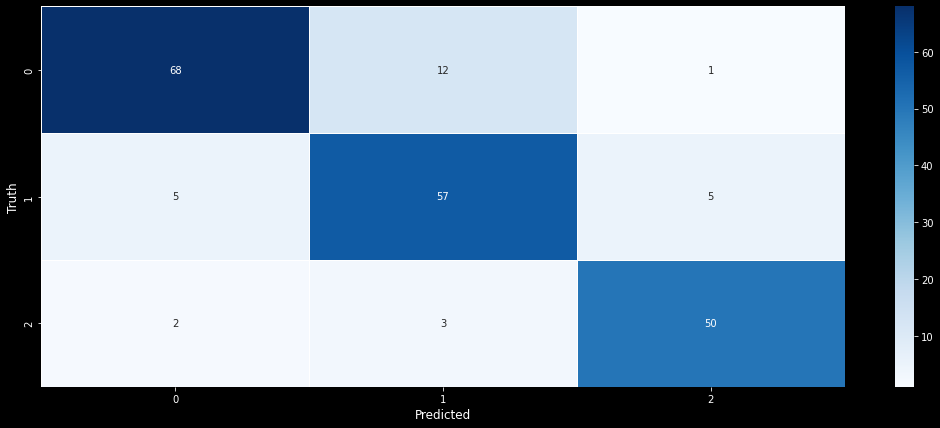

,Truth,Predicted
0,2,2
1,1,1
2,0,1
3,2,2
4,0,0
5,1,1
6,1,1
7,1,1
8,0,0
9,0,0


In [56]:
OVERSAMPLE = 1
build_ml_model()

# Building Artificial Neural Network Model

Trial 30 Complete [00h 00m 18s]
val_accuracy: 0.4506172835826874

Best val_accuracy So Far: 0.7037037014961243
Total elapsed time: 00h 03m 51s
Results summary
Results in ./keras_tuner
Showing 10 best trials
Trial summary
Hyperparameters:
input_00_unit: 192
num_layers: 2
hidden_00_unit: 192
dropout: 0.1
learning_rate: 0.001
hidden_01_unit: 128
hidden_02_unit: 320
hidden_03_unit: 512
hidden_04_unit: 160
hidden_05_unit: 384
hidden_06_unit: 128
hidden_07_unit: 480
hidden_08_unit: 448
hidden_09_unit: 512
hidden_10_unit: 224
hidden_11_unit: 448
hidden_12_unit: 192
hidden_13_unit: 160
hidden_14_unit: 448
hidden_15_unit: 160
hidden_16_unit: 384
hidden_17_unit: 448
hidden_18_unit: 64
hidden_19_unit: 96
hidden_20_unit: 192
hidden_21_unit: 160
hidden_22_unit: 448
hidden_23_unit: 192
hidden_24_unit: 64
hidden_25_unit: 160
hidden_26_unit: 512
hidden_27_unit: 192
hidden_28_unit: 480
hidden_29_unit: 288
hidden_30_unit: 288
hidden_31_unit: 448
hidden_32_unit: 192
hidden_33_unit: 192
hidden_34_unit: 96

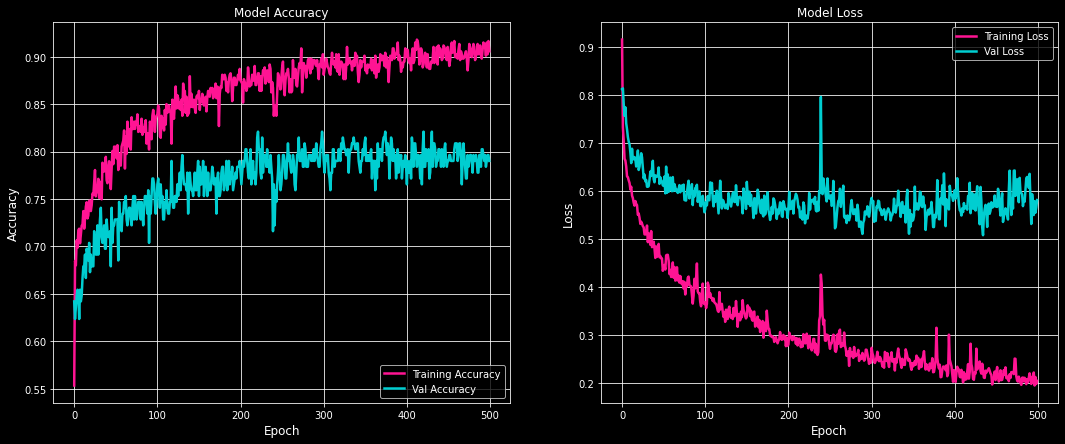

Best epoch: 222
Epoch 1/222
11/11 [==============================] - 1s 22ms/step - loss: 0.9326 - accuracy: 0.5672 - val_loss: 0.8111 - val_accuracy: 0.6667
Epoch 2/222
11/11 [==============================] - 0s 7ms/step - loss: 0.7445 - accuracy: 0.6878 - val_loss: 0.7960 - val_accuracy: 0.6605
Epoch 3/222
11/11 [==============================] - 0s 7ms/step - loss: 0.6903 - accuracy: 0.7094 - val_loss: 0.7828 - val_accuracy: 0.6235
Epoch 4/222
11/11 [==============================] - 0s 7ms/step - loss: 0.6663 - accuracy: 0.7017 - val_loss: 0.7401 - val_accuracy: 0.6728
Epoch 5/222
11/11 [==============================] - 0s 7ms/step - loss: 0.6445 - accuracy: 0.7187 - val_loss: 0.7372 - val_accuracy: 0.6481
Epoch 6/222
11/11 [==============================] - 0s 7ms/step - loss: 0.6482 - accuracy: 0.6878 - val_loss: 0.7220 - val_accuracy: 0.6605
Epoch 7/222
11/11 [==============================] - 0s 7ms/step - loss: 0.6263 - accuracy: 0.7202 - val_loss: 0.7106 - val_accuracy: 0.6

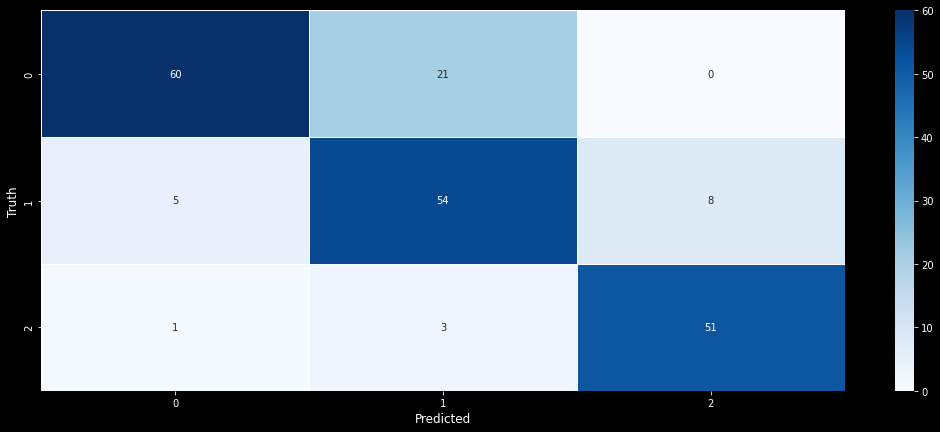

,Truth,Predicted
0,2,2
1,1,1
2,0,1
3,2,2
4,0,0
5,1,2
6,1,1
7,1,1
8,0,0
9,0,1


In [57]:
OVERSAMPLE = 0
model = build_dl_model(*train_dl_model())

# Saving the Model for Deployment

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 192)               1344      
_________________________________________________________________
dense_67 (Dense)             (None, 192)               37056     
_________________________________________________________________
dropout_62 (Dropout)         (None, 192)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 128)               24704     
_________________________________________________________________
dropout_63 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 3)                 387       
Total params: 63,491
Trainable params: 63,491
Non-trainable params: 0
__________________________________________________

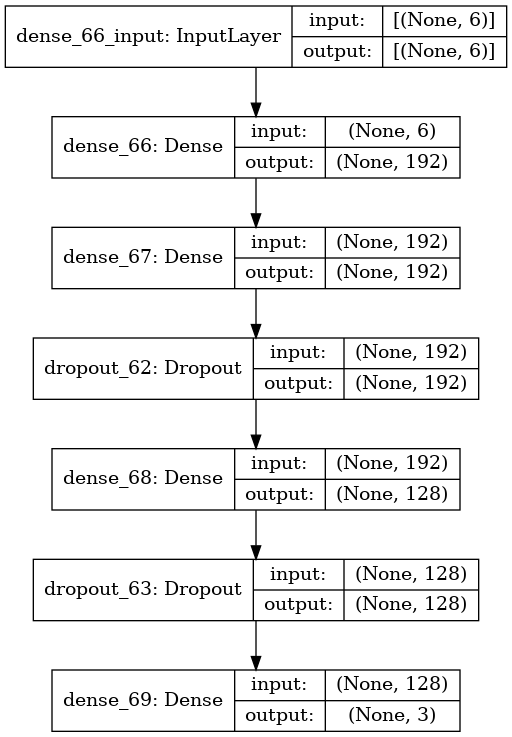

In [58]:
model.save(f"model_{time_stamp}")
shutil.make_archive(f"model_{time_stamp}", "zip", f"./model_{time_stamp}")
dump(preprocessor, open(f"preprocessor.pkl", "wb"))
model.summary()
plot_model(model, show_shapes=True)